In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import init
from torch.utils.data import TensorDataset, DataLoader
import torch.autograd as autograd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OrdinalEncoder,
    StandardScaler,
    OneHotEncoder
)
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm
from statsmodels.formula.api import glm
import math
from scipy.interpolate import UnivariateSpline

freMTPLfreq contains 11 columns:

- `IDpol`: The policy ID (used to link with the claims dataset).  
- `ClaimNb`: Number of claims during the exposure period.  
- `Exposure`: The period of exposure for a policy, in years.
- `Area`: Population density category of the city/community the driver lives in; these categories are ordered from "A" (rural) to "F" (urban center).
- `VehPower`: The power of the car (ordered categorical).  
- `VehAge`: The vehicle age, in years.
- `DrivAge`: The driver age, in years (in France, people can drive a car at 18).
- `VehBrand`: The car brand divided in the following groups: A- Renaut Nissan and Citroen, B- Volkswagen, Audi, Skoda and Seat, C- Opel, General Motors and Ford, D- Fiat, E- Mercedes Chrysler and BMW, F- Japanese (except Nissan) and Korean, G- other.
- `VehGas`: The car gas, Diesel or regular.
- `Density`: The density of inhabitants (number of inhabitants per km2) in the city the driver of the car lives in.
- `Region`: The policy region in France (based on the 1970-2015 classification).

In [2]:
url = "https://raw.githubusercontent.com/sanghuynh0929/DataScienceM2Project/main/freMTPL2freq.parquet"

df = pd.read_parquet(url)

rng = np.random.default_rng(42)
df["RandN"] = rng.normal(0, 1, size=len(df))  # Normal random component for hypothesis testing
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,RandN
0,1.0,1,0.10000,D,5,0,55,50,B12,Regular,1217,R82,0.304717
1,3.0,1,0.77000,D,5,0,55,50,B12,Regular,1217,R82,-1.039984
2,5.0,1,0.75000,B,6,2,52,50,B12,Diesel,54,R22,0.750451
3,10.0,1,0.09000,B,7,0,46,50,B12,Diesel,76,R72,0.940565
4,11.0,1,0.84000,B,7,0,46,50,B12,Diesel,76,R72,-1.951035
...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93,-0.492495
678009,6114327.0,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11,-0.351438
678010,6114328.0,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,0.625221
678011,6114329.0,0,0.00274,B,4,0,60,50,B12,Regular,95,R26,-0.092617


In [3]:
from sklearn.model_selection import train_test_split

# Assuming the target variable is 'ClaimNb'
# You might need to adjust 'target_variable' based on your analysis goals.
target_variable = 'ClaimNb'

X = df.drop(columns=[target_variable])
y = df[target_variable]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.25, random_state=420)

v_train = X_train_raw['Exposure']
v_val = X_val_raw['Exposure']
v_test = X_test_raw['Exposure']

print(f"Shape of X_train: {X_train_raw.shape}")
print(f"Shape of X_val: {X_val_raw.shape}")
print(f"Shape of X_test: {X_test_raw.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (406807, 12)
Shape of X_val: (135603, 12)
Shape of X_test: (135603, 12)
Shape of y_train: (406807,)
Shape of y_val: (135603,)
Shape of y_test: (135603,)


In [4]:
def clip_and_scale(upper):
    pipe = Pipeline(
        steps=[
            ("clip", FunctionTransformer(lambda x: np.clip(x, a_min=0, a_max=upper))),
            ("scale", StandardScaler()),
        ]
    )
    return pipe

density_pipeline = Pipeline(
    steps=[
        ("log", FunctionTransformer(lambda x: np.log(x).round(2))),
        ("scale", StandardScaler()),
    ]
)

area_pipeline = Pipeline(
    steps=[
        ("encode", OrdinalEncoder()),
        ("scale", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        (
            "scale",
            clip_and_scale([20, 90, 150, 15]),
            ["VehAge", "DrivAge", "BonusMalus", "VehPower"],
        ),
        ("area", area_pipeline, ["Area"]),
        ("density", density_pipeline, ["Density"]),
        (
            "veh_gas",
            FunctionTransformer(lambda x: (x == "Diesel").astype(np.float32)),
            ["VehGas"],
        ),
        ("veh_brand", OrdinalEncoder(), ["VehBrand", "Region"]),
        ("passthrough", "passthrough", ["RandN"]),
    ],
    verbose_feature_names_out=False,
)

In [5]:
preprocessor.set_output(transform="pandas").fit(X_train_raw)
X_train = preprocessor.transform(X_train_raw)
X_val = preprocessor.transform(X_val_raw)
X_test = preprocessor.transform(X_test_raw)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32, device=device)


y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32, device=device)

v_train_tensor = torch.tensor(v_train.values, dtype=torch.float32, device=device)
v_val_tensor = torch.tensor(v_val.values, dtype=torch.float32, device=device)
v_test_tensor = torch.tensor(v_test.values, dtype=torch.float32, device=device)

## Models with Numerical Covariates

In [8]:
class LocalGLMNet(nn.Module):
    def __init__(self, seed, n_features, hidden_layers, intercept=None, glm_coefs=None):
        super().__init__()
        torch.manual_seed(seed)


        self.hidden_layers = nn.ModuleList()

        for i in range(len(hidden_layers)):
            if i == 0:
                self.hidden_layers.append(nn.Linear(n_features, hidden_layers[i]))
            else:
                self.hidden_layers.append(
                    nn.Linear(hidden_layers[i - 1], hidden_layers[i])
                )

        self.local_glm = nn.Linear(hidden_layers[-1], n_features)
        if glm_coefs is not None:
          self.local_glm.bias.data = torch.tensor(glm_coefs, dtype=torch.float32)
        else:
          init.constant_(self.local_glm.bias, 0.0)
        init.constant_(self.local_glm.weight, 0.0)
        if intercept is not None:
          self.intercept = nn.Parameter(torch.tensor(intercept, dtype=torch.float32))
        else:
          self.intercept = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))


    def forward(self, x, v, get_attentions=False):
        z = torch.tanh(self.hidden_layers[0](x))
        for layer in self.hidden_layers[1:]:
            z = torch.tanh(layer(z))

        z = self.local_glm(z)
        if get_attentions:
            return z
        skip_connection = torch.einsum("ij,ij->i", z, x).unsqueeze(1)
        z = self.intercept + skip_connection
        return torch.exp(z).flatten() * v

In [9]:
def train_model(model,
                train_loader,
                val_loader,
                optimizer,
                checkpoint_path,
                n_epochs=100,
                device='cpu'):
  '''
  General model training function
  '''

  loss_fn = nn.PoissonNLLLoss(log_input=False, reduction='sum')
  best_val_loss = float('inf')
  history = {'loss': [], 'val_loss': []}

  for epoch in range(n_epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    train_exposure = 0.0
    for batch_idx, (X_batch, v_batch, y_batch) in enumerate(train_loader):
      pred_batch = model(X_batch, v_batch)
      loss = loss_fn(pred_batch, y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      train_exposure += v_batch.sum().item()
    epoch_loss /= train_exposure
    history['loss'].append(epoch_loss)

    model.eval()
    with torch.no_grad():
      val_loss = 0.0
      val_exposure = 0.0
      for batch_idx, (X_batch, v_batch, y_batch) in enumerate(val_loader):
        pred_val = model(X_batch, v_batch)
        loss = loss_fn(pred_val, y_batch)
        val_loss += loss.item()
        val_exposure += v_batch.sum().item()
      val_loss /= val_exposure
      history['val_loss'].append(val_loss)

    if val_loss < best_val_loss and isinstance(checkpoint_path, str):
      best_val_loss = val_loss
      torch.save(model.state_dict(), checkpoint_path)

    if (epoch + 1) % 10 == 0:
      print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
  return history


def score(model, X, y, v):
    """Evaluate the model using sklearn's mean_poisson_deviance."""
    pred = model(X, v).cpu().detach().numpy()
    return 100 * mean_poisson_deviance(
        y.cpu().detach().numpy() / v.cpu().detach().numpy(), pred / v.cpu().detach().numpy(), sample_weight=v.cpu().detach().numpy()
    )

In [10]:
numerical_cols = ["VehAge","DrivAge","BonusMalus","VehPower","Area","Density","VehGas","RandN"]


# Numerical covariates
X_train_num = X_train[numerical_cols]
X_val_num = X_val[numerical_cols]
X_test_num = X_test[numerical_cols]

X_train_num_tensor = torch.tensor(X_train_num.values, dtype=torch.float32, device=device)
X_val_num_tensor = torch.tensor(X_val_num.values, dtype=torch.float32, device=device)
X_test_num_tensor = torch.tensor(X_test_num.values, dtype=torch.float32, device=device)

train_num_dataset = TensorDataset(X_train_num_tensor, v_train_tensor, y_train_tensor)
val_num_dataset = TensorDataset(X_val_num_tensor, v_val_tensor, y_val_tensor)
test_num_dataset = TensorDataset(X_test_num_tensor, v_test_tensor, y_test_tensor)

batch_size = 1024

# Create DataLoader instances
train_num_loader = DataLoader(train_num_dataset, batch_size=batch_size, shuffle=False)
val_num_loader = DataLoader(val_num_dataset, batch_size=batch_size, shuffle=False)
test_num_loader = DataLoader(test_num_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
glm_num = glm(
    formula='ClaimNb ~ VehAge + DrivAge + BonusMalus + VehPower + Area + Density + VehGas + RandN',
    data=pd.concat([X_train, y_train], axis=1),
    family=sm.families.Poisson(),
    exposure=v_train
)
glm_results_num = glm_num.fit()
glm_results_num.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               406807
Model:                            GLM   Df Residuals:                   406798
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85899.
Date:                Tue, 06 Jan 2026   Deviance:                   1.3029e+05
Time:                        21:17:44   Pearson chi2:                 1.12e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01007
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2906      0.010   -238.051      0.0

In [ ]:
# Define hyperparameters
HIDDEN = [48, 32, 24, 16]
SEED = 42

model_num = LocalGLMNet(
    seed=SEED,
    n_features=len(numerical_cols),
    hidden_layers=HIDDEN,
    intercept=glm_results_num.params['Intercept'],
    glm_coefs=glm_results_num.params[1:].values
)
model_num.to(device)

LocalGLMNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=8, out_features=48, bias=True)
    (1): Linear(in_features=48, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=24, bias=True)
    (3): Linear(in_features=24, out_features=16, bias=True)
  )
  (local_glm): Linear(in_features=16, out_features=8, bias=True)
)

In [13]:
poisson_deviance_train_glm = score(model_num, X=X_train_num_tensor, v=v_train_tensor, y=y_train_tensor)
poisson_deviance_test_glm = score(model_num, X=X_test_num_tensor, v=v_test_tensor, y=y_test_tensor)

print(f"Poisson Deviance in GLM with numerical features only (Train): {poisson_deviance_train_glm:.3f}")
print(f"Poisson Deviance in GLM  with numerical features only (Test): {poisson_deviance_test_glm:.3f}")

Poisson Deviance in GLM with numerical features only (Train): 60.605
Poisson Deviance in GLM  with numerical features only (Test): 61.033


In [ ]:
optimizer = torch.optim.NAdam(model_num.parameters(), lr=1e-3)
checkpoint_path = f"./ModelNum_PyTorch_{SEED}.pt"

n_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the selected device

history = train_model(
    model_num, train_num_loader, val_num_loader, optimizer, checkpoint_path, n_epochs, device
)

SyntaxError: invalid syntax (2978808596.py, line 13)

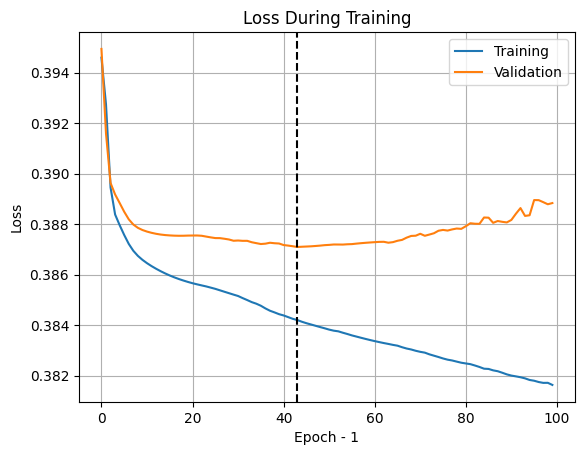

In [15]:
fig = (
    pd.DataFrame({"loss": history["loss"], "val_loss": history["val_loss"]})
    .rename(columns={"loss": "Training", "val_loss": "Validation"})
    .plot(xlabel="Epoch - 1", ylabel="Loss", title="Loss During Training", grid=True)
)
_ = fig.axvline(np.argmin(history["val_loss"]), color="black", linestyle="--")

In [16]:
model_num.load_state_dict(torch.load(checkpoint_path))

poisson_deviance_train_glmnet = score(model_num, X=X_train_num_tensor, v=v_train_tensor, y=y_train_tensor)
poisson_deviance_test_glmnet = score(model_num, X=X_test_num_tensor, v=v_test_tensor, y=y_test_tensor)

print(f"Poisson Deviance in LocalGLMNet with numerical features only (Train): {poisson_deviance_train_glmnet:.3f}")
print(f"Poisson Deviance in LocalGLMNet with numerical features only (Test): {poisson_deviance_test_glmnet:.3f}")

Poisson Deviance in LocalGLMNet with numerical features only (Train): 58.272
Poisson Deviance in LocalGLMNet with numerical features only (Test): 59.260


In [17]:
attention_weights = model_num(X_test_num_tensor, v_test_tensor, get_attentions=True).cpu().detach().numpy()
attention_df = pd.DataFrame(attention_weights, columns=numerical_cols)

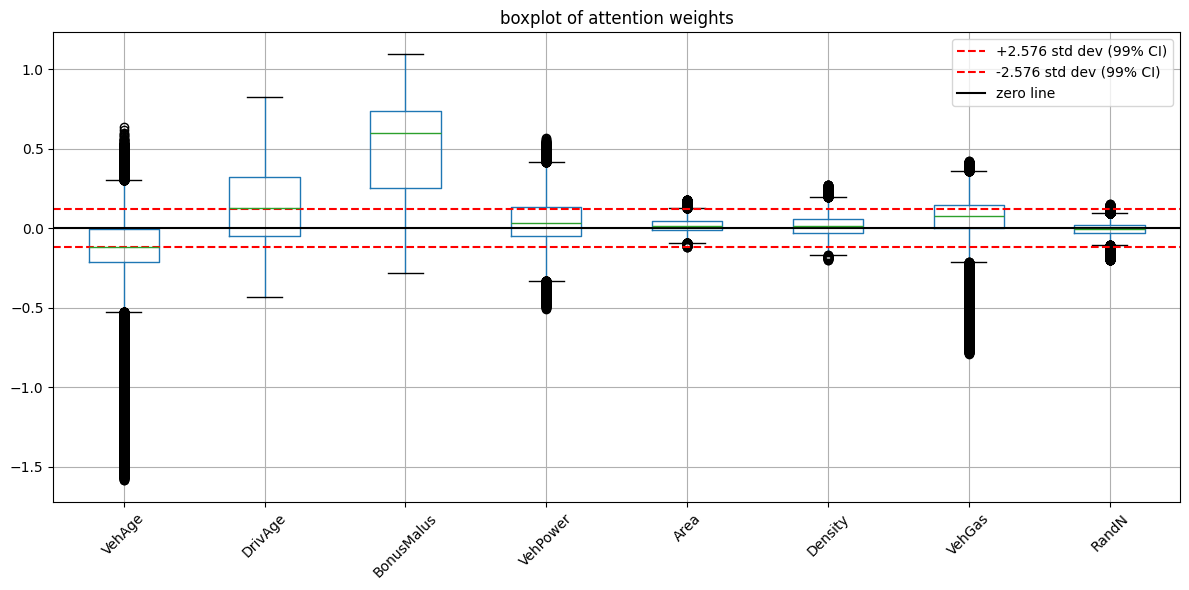

In [18]:
randnx_std = attention_df["RandN"].std()
threshold = 2.576 * randnx_std

# Plot attention weights
plt.figure(figsize=(12, 6))
attention_df.boxplot()
plt.xticks(rotation=45)
plt.title("boxplot of attention weights")
plt.axhline(y=threshold, color="r", linestyle="--", label="+2.576 std dev (99% CI)")
plt.axhline(y=-threshold, color="r", linestyle="--", label="-2.576 std dev (99% CI)")
plt.axhline(y=0, color="k", linestyle="-", label="zero line")
plt.legend()
plt.tight_layout()
plt.show()

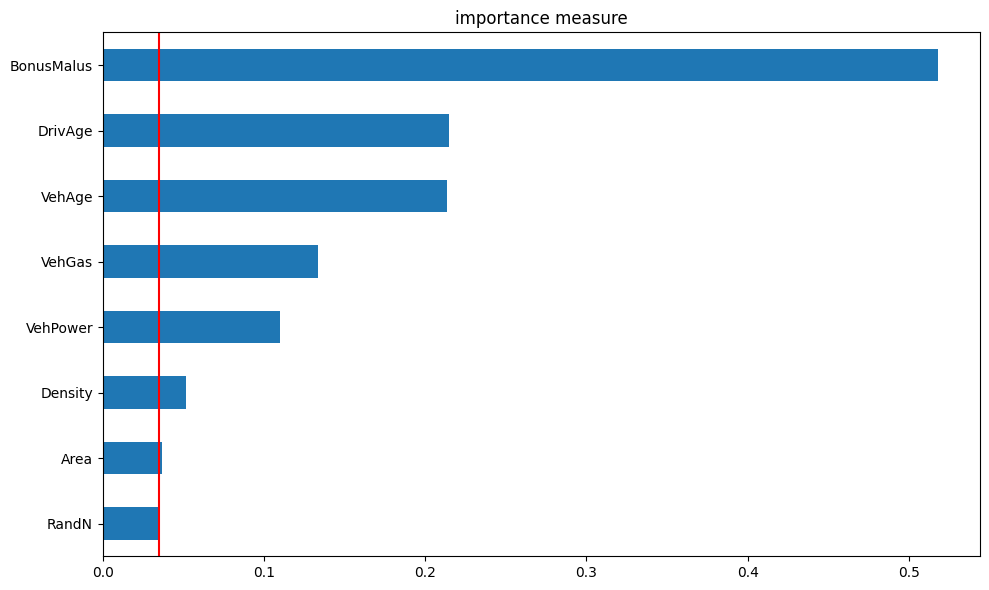

In [19]:
vi = np.abs(attention_df).mean()
vi = vi.sort_values()

# Plot importance measure
plt.figure(figsize=(10, 6))
vi.plot(kind="barh")
# Add vertical line for AreaX importance
area_importance = vi["RandN"]
plt.axvline(x=area_importance, color="red", linestyle="-", label="RandN importance")
plt.title("importance measure")
plt.tight_layout()
plt.show()

### Attention weights

In [20]:
def plot_attention_weights(feature_name, alpha, X_test, ax, attention_df, loess=True):
    # Scatter plot
    ax.scatter(
        X_test[feature_name],
        attention_df[feature_name],
        alpha=0.5,
        s=15,
        label="attention weights",
    )

    # Reference lines
    ax.axhline(0, color="cyan", linestyle="-")
    ax.axhline(0.674 * randnx_std, color="orange", linestyle="-")
    ax.axhline(-0.674 * randnx_std, color="orange", linestyle="-")
    ax.axhline(2.576 * randnx_std, color="red", linestyle="-")
    ax.axhline(-2.576 * randnx_std, color="red", linestyle="-")

    # Shaded area
    ax.fill_between(
        [X_test[feature_name].min(), X_test[feature_name].max()],
        -0.674 * randnx_std,
        0.674 * randnx_std,
        color="orange",
        alpha=0.3,
    )

    if loess:
        from statsmodels.nonparametric.smoothers_lowess import lowess

        sorted_idx = np.argsort(X_test[feature_name])
        x_sorted = X_test[feature_name].iloc[sorted_idx]
        y_sorted = attention_df[feature_name].iloc[sorted_idx]

        lowess_fit = lowess(y_sorted, x_sorted, frac=alpha, it=3)

        ax.plot(
            lowess_fit[:, 0],
            lowess_fit[:, 1],
            color="lightgreen",
            linewidth=2,
        )

    # Labels
    ax.set_title(feature_name, fontsize=11)
    # ax.set_xlabel(feature_name)
    ax.set_ylabel("attention weight")

    ylim0 = np.max(np.abs(attention_df))
    ax.set_ylim(-ylim0, ylim0)


/Users/sanghuynh/miniconda3/envs/AutoQuant/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/sanghuynh/miniconda3/envs/AutoQuant/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


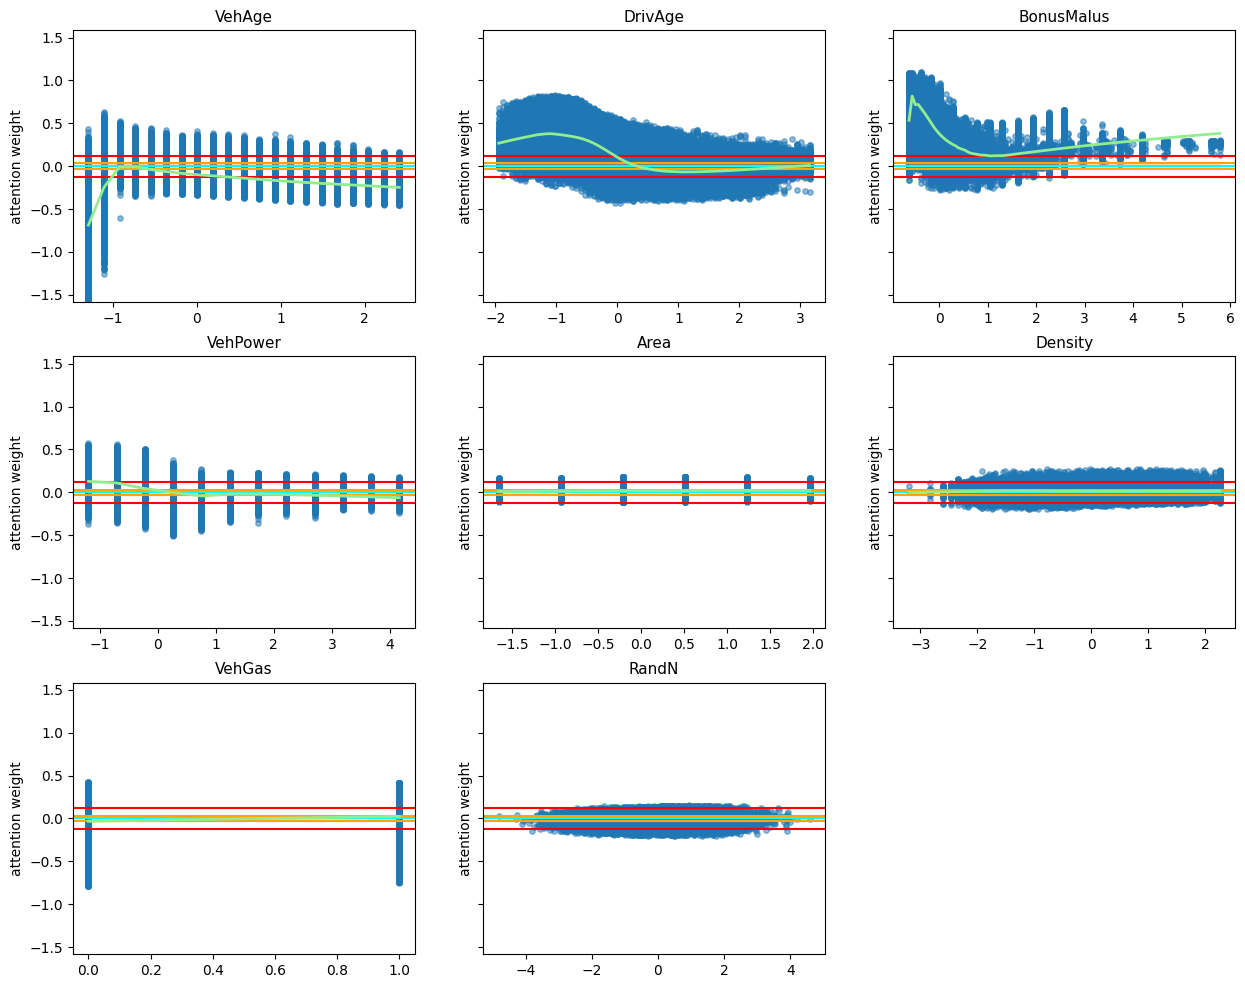

In [21]:
import math

n_features = len(numerical_cols)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 4 * n_rows),
    sharey=True
)

axes = axes.flatten()

for i, feature_name in enumerate(numerical_cols):
    ax = axes[i]

    if feature_name == "RandN":
        plot_attention_weights(feature_name, 0.3, X_test, ax, attention_df, loess=False)
    else:
        plot_attention_weights(feature_name, 0.3, X_test, ax, attention_df)

# Xóa các subplot thừa (nếu có)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])



### Interaction

In [22]:
n, p = X_test_num.shape
gradients = np.empty((p, n, p))
input_tensor = X_test_num_tensor

input_tensor.requires_grad = True
attentions = model_num(X_test_num_tensor, v_test_tensor, get_attentions=True)
for i in range(p):
    grad_scaling = torch.ones_like(attentions[:, i])
    gradient_i = autograd.grad(
        attentions[:, i], input_tensor, grad_scaling, create_graph=True
    )
    gradients[i, :, :] = gradient_i[0].numpy(force=True)

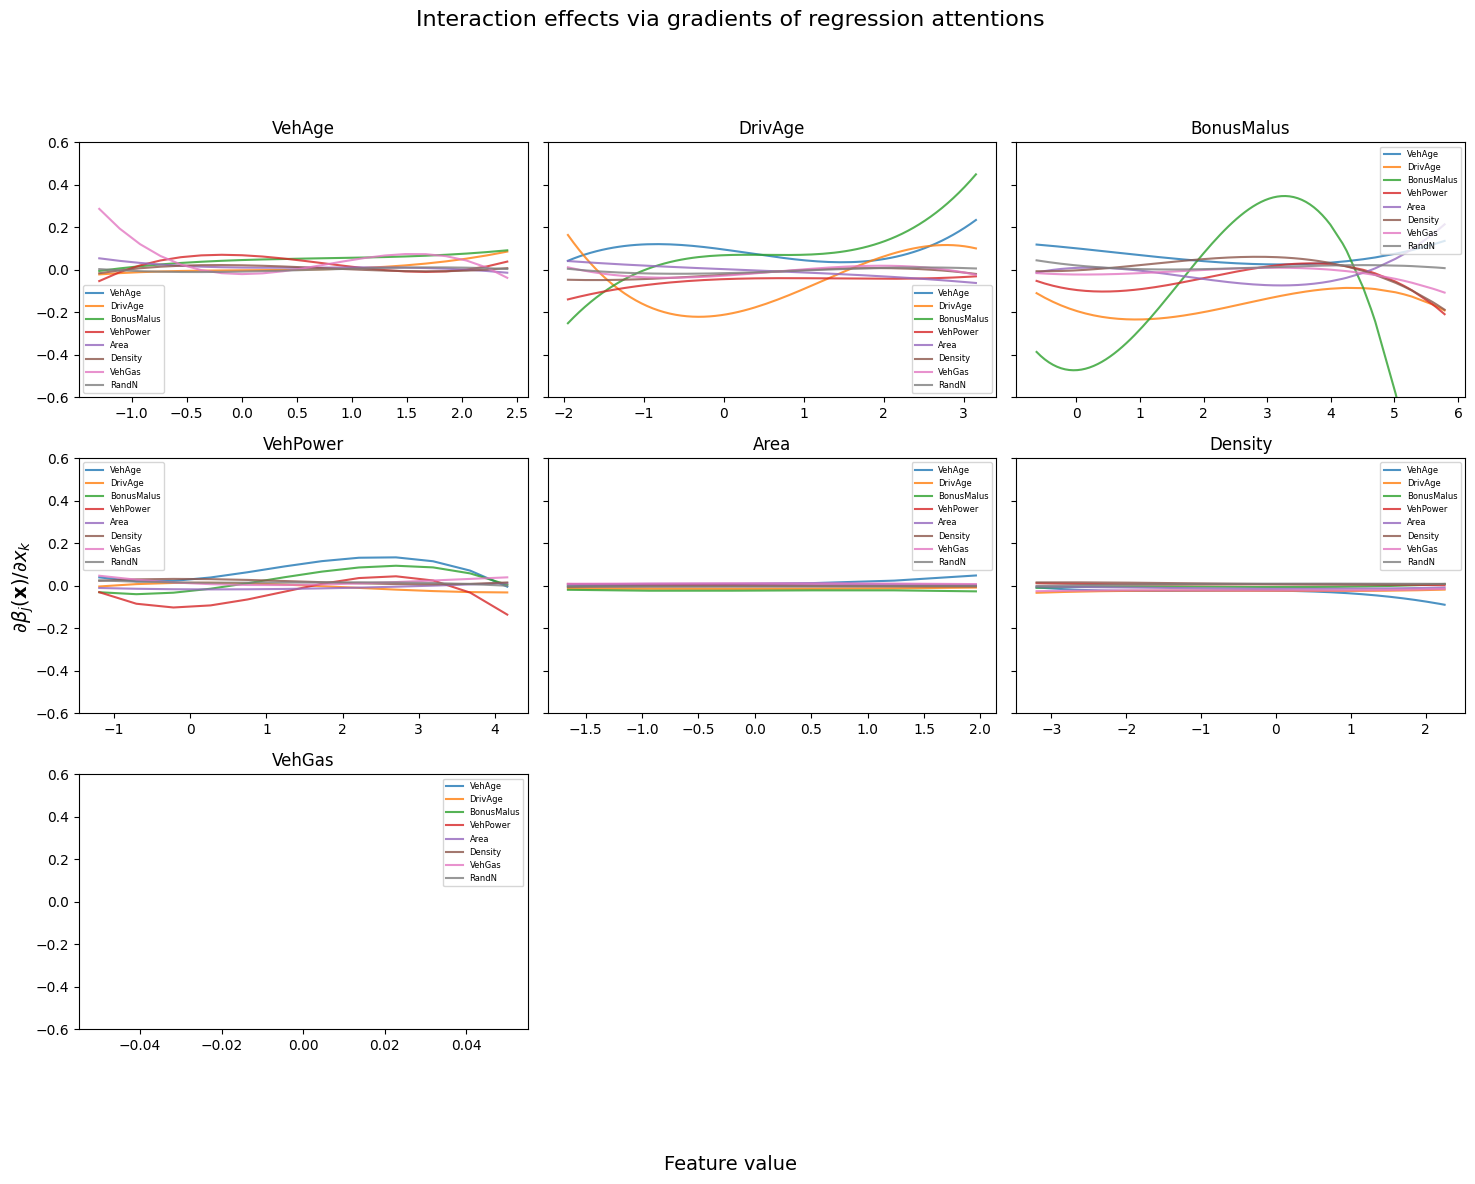

In [23]:
vars_x = numerical_cols[:-1]  # bỏ RandN nếu muốn
n_plots = len(vars_x)

n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 4 * n_rows),
    sharey=True
)

axes = axes.flatten()
for i, var_x in enumerate(vars_x):
    ax = axes[i]
    var_x_idx = attention_df.columns.get_loc(var_x)

    for derivative_wrt in attention_df.columns:
        idx_var_derivative = attention_df.columns.get_loc(derivative_wrt)

        x = X_test_num[var_x].values
        y_data = gradients[var_x_idx, :, idx_var_derivative]

        # sort
        sort_idx = np.argsort(x)
        x_sorted = x[sort_idx]
        y_sorted = y_data[sort_idx]

        # spline smoothing
        spline = UnivariateSpline(x_sorted, y_sorted, k=3, s=None)
        kk = np.sort(x)
        spline0 = spline(kk)

        ax.plot(kk, spline0, alpha=0.8, linewidth=1.5, label=derivative_wrt)

    ax.set_title(var_x, fontsize=12)
    ax.set_ylim([-0.6, 0.6])
    ax.legend(fontsize=6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.supxlabel("Feature value", fontsize=14)
fig.supylabel(r"$\partial \beta_j(\mathbf{x}) / \partial x_k$", fontsize=14)

fig.suptitle("Interaction effects via gradients of regression attentions", fontsize=16)

fig.tight_layout(rect=[0, 0.07, 1, 0.93])
plt.show()

In [ ]:
# Cold-start model without initialization
HIDDEN = [32, 24, 16]
SEED = 42

model_num_cold = LocalGLMNet(
    seed=SEED,
    n_features=len(numerical_cols),
    hidden_layers=HIDDEN,
)
model_num_cold.to(device)

optimizer = torch.optim.NAdam(model_num_cold.parameters(), lr=1e-3)
checkpoint_path = f"./ModelNumCold_PyTorch_{SEED}.pt"

n_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the selected device

history = train_model(
    model_num_cold, train_num_loader, val_num_loader, optimizer, checkpoint_path, n_epochs, device
)

Using device: cpu
Epoch 10/100, Loss: 0.3941, Val Loss: 0.3960
Epoch 20/100, Loss: 0.3911, Val Loss: 0.3934
Epoch 30/100, Loss: 0.3884, Val Loss: 0.3908
Epoch 40/100, Loss: 0.3864, Val Loss: 0.3891
Epoch 50/100, Loss: 0.3852, Val Loss: 0.3883
Epoch 60/100, Loss: 0.3846, Val Loss: 0.3881
Epoch 70/100, Loss: 0.3842, Val Loss: 0.3880
Epoch 80/100, Loss: 0.3839, Val Loss: 0.3880
Epoch 90/100, Loss: 0.3836, Val Loss: 0.3881
Epoch 100/100, Loss: 0.3833, Val Loss: 0.3881


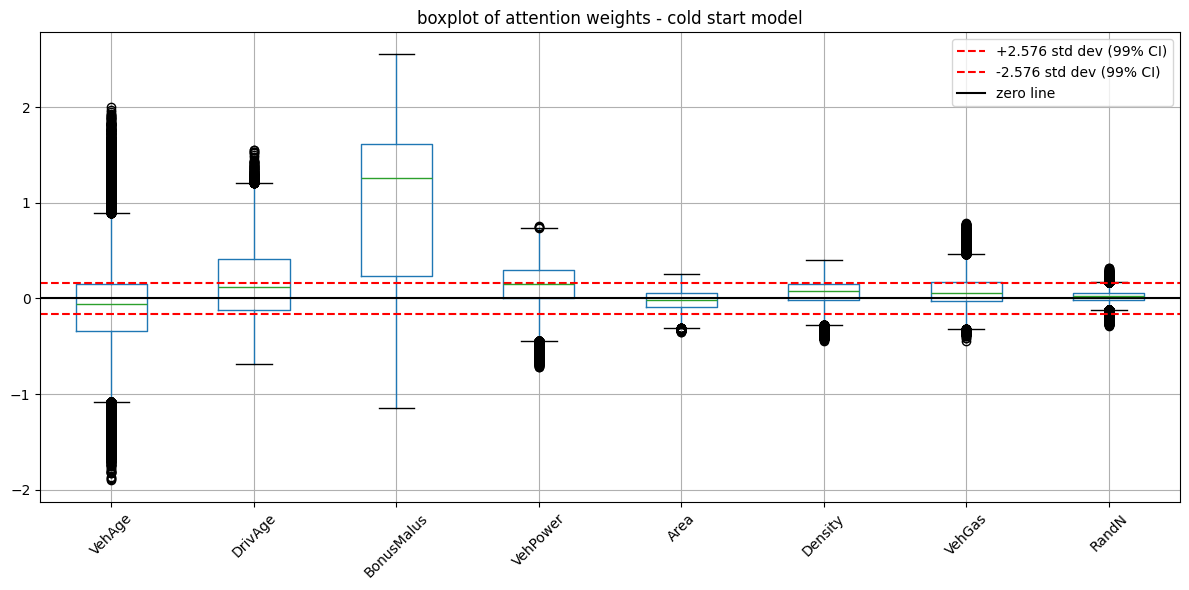

In [25]:
attention_weights = model_num_cold(X_test_num_tensor, v_test_tensor, get_attentions=True).cpu().detach().numpy()
attention_df = pd.DataFrame(attention_weights, columns=numerical_cols)

randnx_std = attention_df["RandN"].std()
threshold = 2.576 * randnx_std

# Plot attention weights
plt.figure(figsize=(12, 6))
attention_df.boxplot()
plt.xticks(rotation=45)
plt.title("boxplot of attention weights - cold start model")
plt.axhline(y=threshold, color="r", linestyle="--", label="+2.576 std dev (99% CI)")
plt.axhline(y=-threshold, color="r", linestyle="--", label="-2.576 std dev (99% CI)")
plt.axhline(y=0, color="k", linestyle="-", label="zero line")
plt.legend()
plt.tight_layout()
plt.show()

## Models with Numerical and Categorical Covariates

### FNN Embedding

In [26]:
class FNN(nn.Module):
    def __init__(self, seed, n_features, hidden_layers,
                 kk, bb, y0):
        super().__init__()
        torch.manual_seed(seed)

        # ---- Categorical embeddings ----
        self.brand_embed = nn.Embedding(kk[0], bb[0])
        self.region_embed = nn.Embedding(kk[1], bb[1])

        self.cat_dim = bb[0] + bb[1]   # used only by MLP

        # ---- Continuous feature count ----
        n_cont = n_features - 2

        # ---- MLP after transformer ----
        mlp_input_dim = n_cont + self.cat_dim

        self.hidden_layers = nn.ModuleList()
        for i, h in enumerate(hidden_layers):
            in_dim = mlp_input_dim if i == 0 else hidden_layers[i-1]
            self.hidden_layers.append(nn.Linear(in_dim, h))

        self.output_layer = nn.Linear(hidden_layers[-1], 1)
        init.constant_(self.output_layer.weight, 0.0)
        init.constant_(self.output_layer.bias, y0)

    def forward(self, x, v):
        # ------------ Prepare categorical tokens -------------
        brand_emb = self.brand_embed(x[:, -3].long())
        region_emb = self.region_embed(x[:, -2].long())
        # ------------ Prepare continuous features ------------
        cont_x = torch.cat((x[:, :-3], x[:, -1:]), dim=1)
        z = torch.cat([cont_x, brand_emb, region_emb], dim=1)

        # ------------------ MLP forward ----------------------

        for layer in self.hidden_layers:
            z = torch.tanh(layer(z))

        out = torch.exp(self.output_layer(z)).flatten()
        return out * v

In [27]:
SEED = 1234
M_FEAT = X_train.shape[1]
HIDDEN = [64, 48, 32, 16]
mu_hom = y_train.sum() / v_train.sum()  # homogeneous frequency
KK = [len(X_train['VehBrand'].unique()), len(X_train['Region'].unique())]  # number of categories
BB = [2, 4]  # embedding dimensions for brand and region


model_fnn = FNN(
    SEED, n_features=M_FEAT, hidden_layers=HIDDEN, kk=KK, bb=BB, y0=np.log(mu_hom)
)
model_fnn.to(device)

FNN(
  (brand_embed): Embedding(11, 2)
  (region_embed): Embedding(22, 4)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=48, bias=True)
    (2): Linear(in_features=48, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

In [28]:
train_dataset = TensorDataset(X_train_tensor, v_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, v_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, v_test_tensor, y_test_tensor)

batch_size = 1024

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer = torch.optim.NAdam(model_fnn.parameters(), lr=1e-3)
checkpoint_path = f"./FNN_emb_PyTorch_{SEED}.pt"
n_epochs = 100
history = train_model(
    model_fnn, train_loader, val_loader, optimizer, checkpoint_path, n_epochs, device
)

Epoch 10/100, Loss: 0.3839, Val Loss: 0.3849
Epoch 20/100, Loss: 0.3821, Val Loss: 0.3840
Epoch 30/100, Loss: 0.3809, Val Loss: 0.3839
Epoch 40/100, Loss: 0.3796, Val Loss: 0.3841
Epoch 50/100, Loss: 0.3782, Val Loss: 0.3842
Epoch 60/100, Loss: 0.3767, Val Loss: 0.3847
Epoch 70/100, Loss: 0.3750, Val Loss: 0.3855
Epoch 80/100, Loss: 0.3731, Val Loss: 0.3868
Epoch 90/100, Loss: 0.3712, Val Loss: 0.3883
Epoch 100/100, Loss: 0.3693, Val Loss: 0.3898


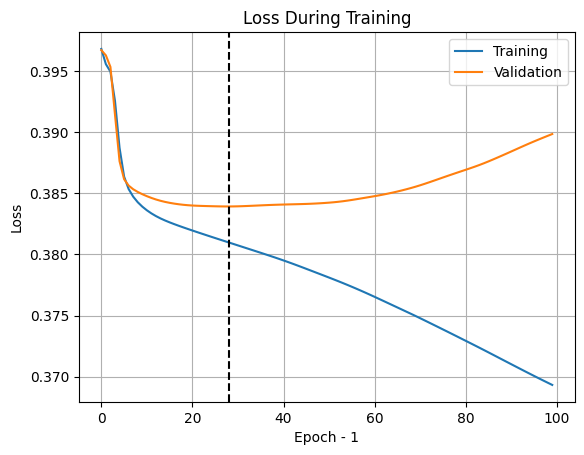

In [30]:
fig = (
    pd.DataFrame({"loss": history["loss"], "val_loss": history["val_loss"]})
    .rename(columns={"loss": "Training", "val_loss": "Validation"})
    .plot(xlabel="Epoch - 1", ylabel="Loss", title="Loss During Training", grid=True)
)
_ = fig.axvline(np.argmin(history["val_loss"]), color="black", linestyle="--")

In [31]:
model_fnn.load_state_dict(torch.load(checkpoint_path))

print(f"Poisson Deviance (Learn): {score(model_fnn, X_train_tensor, y_train_tensor, v_train_tensor):.3f}")
print(f"Poisson Deviance (Test): {score(model_fnn, X_test_tensor, y_test_tensor, v_test_tensor):.3f}")

model_fnn.eval()  # Set model to evaluation mode
with torch.no_grad():
    learn_nn = model_fnn(X_train_tensor, v_train_tensor).cpu().detach().numpy()

print(f"Balance Property: {mu_hom:.4f} {learn_nn.sum() / v_train.sum():.4f}")



Poisson Deviance (Learn): 57.611
Poisson Deviance (Test): 58.819
Balance Property: 0.1005 0.1046


In [32]:
full_train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
full_val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

Epoch 10/40, Loss: 0.3803, Val Loss: 0.3838
Epoch 20/40, Loss: 0.3803, Val Loss: 0.3838
Epoch 30/40, Loss: 0.3802, Val Loss: 0.3838
Epoch 40/40, Loss: 0.3802, Val Loss: 0.3838


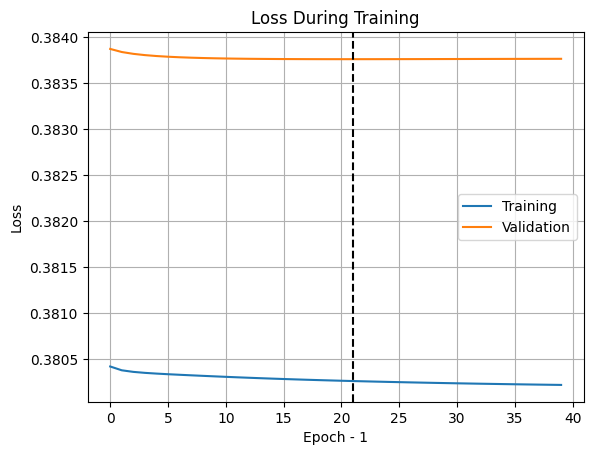

In [33]:
checkpoint_path = f"./FNN2_calibrated_emb_PyTorch_{SEED}.pt"

for el in model_fnn.hidden_layers:
  el.weight.requires_grad_(requires_grad=False)
  el.bias.requires_grad_(requires_grad=False)
model_fnn.brand_embed.weight.requires_grad_(requires_grad=False)
model_fnn.region_embed.weight.requires_grad_(requires_grad=False)

optimizer = torch.optim.NAdam(model_fnn.parameters(), lr=2e-3)

# Full-batch training instead of mini-batch
history = train_model(
    model_fnn,
    full_train_loader,
    full_val_loader,
    optimizer,
    checkpoint_path=checkpoint_path,
    n_epochs=40,
    device=device
)

fig = (
    pd.DataFrame({"loss": history["loss"], "val_loss": history["val_loss"]})
    .rename(columns={"loss": "Training", "val_loss": "Validation"})
    .plot(xlabel="Epoch - 1", ylabel="Loss", title="Loss During Training", grid=True)
)
_ = fig.axvline(np.argmin(history["val_loss"]), color="black", linestyle="--")

In [34]:
print(f"Poisson Deviance (Learn): {score(model_fnn, X_train_tensor, y_train_tensor, v_train_tensor):.3f}")
print(f"Poisson Deviance (Test): {score(model_fnn, X_test_tensor, y_test_tensor, v_test_tensor):.3f}")

model_fnn.eval()  # Set model to evaluation mode
with torch.no_grad():
    learn_nn = model_fnn(X_train_tensor, v_train_tensor).cpu().detach().numpy()

print(f"Balance Property: {mu_hom:.4f} {learn_nn.sum() / v_train.sum():.4f}")

Poisson Deviance (Learn): 57.570
Poisson Deviance (Test): 58.762
Balance Property: 0.1005 0.1007


In [35]:
print("VehBrand Embeddings:")
print(model_fnn.brand_embed.weight.data)
print("\nRegion Embeddings:")
print(model_fnn.region_embed.weight.data)

VehBrand Embeddings:
tensor([[ 0.6484, -0.3067],
        [ 0.6213, -0.6037],
        [-0.2252,  0.3489],
        [-0.7106, -1.0169],
        [ 0.8149, -0.2802],
        [-0.1619,  0.2756],
        [ 0.8816, -0.2144],
        [-0.7870,  1.1620],
        [-2.1461,  1.8089],
        [ 0.5338, -0.2813],
        [-0.7723,  0.7910]])

Region Embeddings:
tensor([[-1.2108e+00,  2.0648e-01,  3.5316e-01, -4.0008e-01],
        [-5.2664e-01,  9.6827e-01, -1.6965e-01,  5.0104e-01],
        [ 1.0379e+00,  3.7856e-02, -1.0720e+00, -8.2284e-03],
        [-1.0079e+00, -6.7096e-01, -5.3571e-01, -1.2400e+00],
        [-8.5842e-01,  1.0108e+00, -4.9380e-01, -1.0329e+00],
        [-2.6982e-01,  2.0491e-01, -4.2507e-01, -1.8062e+00],
        [-8.7123e-01,  6.0639e-01,  2.3326e-01,  2.3953e-01],
        [-7.1793e-01,  8.2760e-01,  1.2977e+00,  1.0233e+00],
        [ 1.7272e-01, -2.1719e-01,  8.1416e-01, -7.1718e-01],
        [-5.3645e-02, -2.7659e-01, -1.1751e-01,  8.4211e-01],
        [-1.0100e+00,  5.6582e

In [36]:
X_train

,VehAge,DrivAge,BonusMalus,VehPower,Area,Density,VehGas,VehBrand,Region,RandN
1861,-1.107974,0.036073,-0.625056,-0.707794,-0.934227,-1.017452,0.0,3.0,20.0,-1.084611
322420,-1.107974,-0.317979,0.016469,-1.194693,-0.210642,-0.701998,1.0,7.0,20.0,-1.506782
296697,-1.107974,-0.317979,-0.625056,1.726705,-1.657812,-1.830145,1.0,4.0,4.0,1.177551
86328,1.485777,-1.592566,2.582572,-1.194693,-0.210642,0.009109,0.0,6.0,4.0,-1.158789
204678,0.003633,-0.672031,0.016469,0.266006,0.512943,0.468923,0.0,3.0,4.0,-0.031337
...,...,...,...,...,...,...,...,...,...,...
84717,1.485777,0.531745,-0.625056,-1.194693,-0.934227,-1.028145,0.0,0.0,12.0,0.422074
585887,0.929973,-0.317979,-0.625056,-0.707794,-1.657812,-1.626972,1.0,8.0,4.0,0.046241
661165,-0.737438,-0.317979,-0.625056,0.752905,1.236529,1.254883,0.0,3.0,11.0,1.326314
127956,0.559437,1.027418,-0.625056,0.266006,-0.210642,-0.611105,0.0,6.0,4.0,-1.713588


In [37]:
brand_categories = preprocessor.named_transformers_['veh_brand'].categories_[0]

weights = model_fnn.brand_embed.weight.cpu().detach().numpy()

brand_mapping_df = pd.DataFrame(weights, columns=[f'VehBrandEmb{i+1}' for i in range(weights.shape[1])])
brand_mapping_df['VehBrand'] = range(len(brand_categories))

region_categories = preprocessor.named_transformers_['veh_brand'].categories_[1]

weights = model_fnn.region_embed.weight.cpu().detach().numpy()

region_mapping_df = pd.DataFrame(weights, columns=[f'RegionEmb{i+1}' for i in range(weights.shape[1])])
region_mapping_df['Region'] = range(len(region_categories))

print("Brand Embedding Mapping:")
print(brand_mapping_df.head())
print("\nRegion Embedding Mapping:")
print(region_mapping_df.head())

Brand Embedding Mapping:
   VehBrandEmb1  VehBrandEmb2  VehBrand
0      0.648399     -0.306696         0
1      0.621323     -0.603678         1
2     -0.225168      0.348891         2
3     -0.710619     -1.016914         3
4      0.814875     -0.280171         4

Region Embedding Mapping:
   RegionEmb1  RegionEmb2  RegionEmb3  RegionEmb4  Region
0   -1.210796    0.206481    0.353156   -0.400082       0
1   -0.526640    0.968266   -0.169652    0.501045       1
2    1.037931    0.037856   -1.072033   -0.008228       2
3   -1.007867   -0.670961   -0.535709   -1.240039       3
4   -0.858423    1.010784   -0.493803   -1.032890       4


In [38]:
original_index = X_train.index
X_train_emb = X_train.merge(brand_mapping_df, on='VehBrand', how='left').merge(region_mapping_df, on='Region', how='left')
X_train_emb.index = original_index

original_index = X_val.index
X_val_emb = X_val.merge(brand_mapping_df, on='VehBrand', how='left').merge(region_mapping_df, on='Region', how='left')
X_val_emb.index = original_index

original_index = X_test.index
X_test_emb = X_test.merge(brand_mapping_df, on='VehBrand', how='left').merge(region_mapping_df, on='Region', how='left')
X_test_emb.index = original_index

X_train_emb

,VehAge,DrivAge,BonusMalus,VehPower,Area,Density,VehGas,VehBrand,Region,RandN,VehBrandEmb1,VehBrandEmb2,RegionEmb1,RegionEmb2,RegionEmb3,RegionEmb4
1861,-1.107974,0.036073,-0.625056,-0.707794,-0.934227,-1.017452,0.0,3.0,20.0,-1.084611,-0.710619,-1.016914,0.162410,-0.481532,-1.560211,0.747412
322420,-1.107974,-0.317979,0.016469,-1.194693,-0.210642,-0.701998,1.0,7.0,20.0,-1.506782,-0.787043,1.162045,0.162410,-0.481532,-1.560211,0.747412
296697,-1.107974,-0.317979,-0.625056,1.726705,-1.657812,-1.830145,1.0,4.0,4.0,1.177551,0.814875,-0.280171,-0.858423,1.010784,-0.493803,-1.032890
86328,1.485777,-1.592566,2.582572,-1.194693,-0.210642,0.009109,0.0,6.0,4.0,-1.158789,0.881596,-0.214372,-0.858423,1.010784,-0.493803,-1.032890
204678,0.003633,-0.672031,0.016469,0.266006,0.512943,0.468923,0.0,3.0,4.0,-0.031337,-0.710619,-1.016914,-0.858423,1.010784,-0.493803,-1.032890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84717,1.485777,0.531745,-0.625056,-1.194693,-0.934227,-1.028145,0.0,0.0,12.0,0.422074,0.648399,-0.306696,-0.685230,0.581835,-1.035725,-0.441437
585887,0.929973,-0.317979,-0.625056,-0.707794,-1.657812,-1.626972,1.0,8.0,4.0,0.046241,-2.146105,1.808891,-0.858423,1.010784,-0.493803,-1.032890
661165,-0.737438,-0.317979,-0.625056,0.752905,1.236529,1.254883,0.0,3.0,11.0,1.326314,-0.710619,-1.016914,2.152103,0.483743,0.116187,-0.261272
127956,0.559437,1.027418,-0.625056,0.266006,-0.210642,-0.611105,0.0,6.0,4.0,-1.713588,0.881596,-0.214372,-0.858423,1.010784,-0.493803,-1.032890


### GLM with Trained Embeddings

In [39]:
cols = ["VehAge","DrivAge","BonusMalus","VehPower","Area","Density","VehGas","RandN",
        "VehBrandEmb1","VehBrandEmb2","RegionEmb1","RegionEmb2","RegionEmb3","RegionEmb4"]


X_train_emb.drop(columns=['VehBrand', 'Region'], inplace=True)
X_val_emb.drop(columns=['VehBrand', 'Region'], inplace=True)
X_test_emb.drop(columns=['VehBrand', 'Region'], inplace=True)

X_train_emb_tensor = torch.tensor(X_train_emb.values, dtype=torch.float32, device=device)
X_val_emb_tensor = torch.tensor(X_val_emb.values, dtype=torch.float32, device=device)
X_test_emb_tensor = torch.tensor(X_test_emb.values, dtype=torch.float32, device=device)

train_emb_dataset = TensorDataset(X_train_emb_tensor, v_train_tensor, y_train_tensor)
val_emb_dataset = TensorDataset(X_val_emb_tensor, v_val_tensor, y_val_tensor)
test_emb_dataset = TensorDataset(X_test_emb_tensor, v_test_tensor, y_test_tensor)

batch_size = 1024

# Create DataLoader instances
train_emb_loader = DataLoader(train_emb_dataset, batch_size=batch_size, shuffle=False)
val_emb_loader = DataLoader(val_emb_dataset, batch_size=batch_size, shuffle=False)
test_emb_loader = DataLoader(test_emb_dataset, batch_size=batch_size, shuffle=False)

In [40]:
glm_emb = glm(
    formula='ClaimNb ~ VehAge + DrivAge + BonusMalus + VehPower + Area + Density + VehGas + RandN + VehBrandEmb1 + VehBrandEmb2 + RegionEmb1 + RegionEmb2 + RegionEmb3 + RegionEmb4',
    data=pd.concat([X_train_emb, y_train], axis=1),
    family=sm.families.Poisson(),
    exposure=v_train
)
glm_results_emb = glm_emb.fit()
glm_results_emb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               406807
Model:                            GLM   Df Residuals:                   406792
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85849.
Date:                Tue, 06 Jan 2026   Deviance:                   1.3019e+05
Time:                        21:40:38   Pearson chi2:                 1.11e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01032
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.3619      0.014   -173.703      0.000      -2.389      -2.335
VehAge          -0.2261      0.008    -27.374      0.000      -0.242      -0.210
DrivAge          0.0919      0.007     12.736      0.000       0.078       0.106
BonusMalus       0.3520      0.006     55.259      0.000       0.339       0.364
VehPower         0.0303      0.007      4.346      0.000       0.017       0.044
Area             0.0098      0.029      0.342      0.732      -0.046       0.066
Density          0.0773      0.029      2.709      0.007       0.021       0.133
VehGas          -0.0455      0.014     -3.236      0.001      -0.073      -0.018
RandN            0.0037      0.007      0.541      0.589      -0.010       0.017
VehBrandEmb1    -0.0487      0.010     -5.026      0.000      -0.068      -0.030
VehBrandEmb2    -0.0844      0.011     -7.696      0.000      -0.106      -0.063
RegionEmb1       0.0101      0.007      1.462      0.144      -0.003       0.024
RegionEmb2       0.0929      0.015      6.326      0.000       0.064       0.122
RegionEmb3      -0.0552      0.011     -5.226      0.000      -0.076      -0.034
RegionEmb4      -0.0046      0.011     -0.413      0.680      -0.026       0.017
================================================================================
"""

In [ ]:
# Define hyperparameters
HIDDEN = [48, 32, 24, 16]
SEED = 42

model_emb = LocalGLMNet(
    seed=SEED,
    n_features=len(cols),
    hidden_layers=HIDDEN,
    intercept=glm_results_emb.params['Intercept'],
    glm_coefs=glm_results_emb.params[1:].values
)
model_emb.to(device)

LocalGLMNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=14, out_features=48, bias=True)
    (1): Linear(in_features=48, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=24, bias=True)
    (3): Linear(in_features=24, out_features=16, bias=True)
  )
  (local_glm): Linear(in_features=16, out_features=14, bias=True)
)

In [42]:
poisson_deviance_train_glm_2 = score(model_emb, X=X_train_emb_tensor, v=v_train_tensor, y=y_train_tensor)
poisson_deviance_test_glm_2 = score(model_emb, X=X_test_emb_tensor, v=v_test_tensor, y=y_test_tensor)

print(f"Poisson Deviance in GLM with embedded features (Train): {poisson_deviance_train_glm_2:.3f}")
print(f"Poisson Deviance in GLM with embedded features (Test): {poisson_deviance_test_glm_2:.3f}")

Poisson Deviance in GLM with embedded features (Train): 60.558
Poisson Deviance in GLM with embedded features (Test): 60.963


In [ ]:
optimizer = torch.optim.NAdam(model_emb.parameters(), lr=1e-3)
checkpoint_path = f"./ModelEmb_PyTorch_{SEED}.pt"

n_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the selected device

history = train_model(
    model_emb, train_emb_loader, val_emb_loader, optimizer, checkpoint_path, n_epochs, device
)

Using device: cpu
Epoch 10/100, Loss: 0.3837, Val Loss: 0.3848
Epoch 20/100, Loss: 0.3821, Val Loss: 0.3845
Epoch 30/100, Loss: 0.3808, Val Loss: 0.3840
Epoch 40/100, Loss: 0.3795, Val Loss: 0.3841
Epoch 50/100, Loss: 0.3784, Val Loss: 0.3845
Epoch 60/100, Loss: 0.3772, Val Loss: 0.3849
Epoch 70/100, Loss: 0.3760, Val Loss: 0.3853
Epoch 80/100, Loss: 0.3749, Val Loss: 0.3859
Epoch 90/100, Loss: 0.3738, Val Loss: 0.3865
Epoch 100/100, Loss: 0.3727, Val Loss: 0.3873


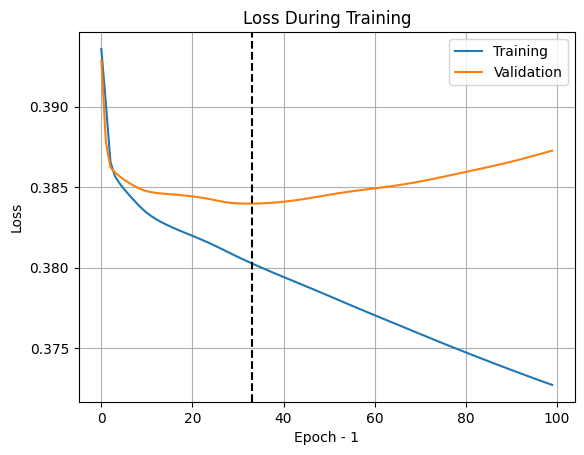

In [44]:
fig = (
    pd.DataFrame({"loss": history["loss"], "val_loss": history["val_loss"]})
    .rename(columns={"loss": "Training", "val_loss": "Validation"})
    .plot(xlabel="Epoch - 1", ylabel="Loss", title="Loss During Training", grid=True)
)
_ = fig.axvline(np.argmin(history["val_loss"]), color="black", linestyle="--")

In [45]:
model_emb.load_state_dict(torch.load(checkpoint_path))

poisson_deviance_train_glmnet_2 = score(model_emb, X=X_train_emb_tensor, v=v_train_tensor, y=y_train_tensor)
poisson_deviance_test_glmnet_2 = score(model_emb, X=X_test_emb_tensor, v=v_test_tensor, y=y_test_tensor)

print(f"Poisson Deviance in LocalGLMNet with embedded features (Train): {poisson_deviance_train_glmnet_2:.3f}")
print(f"Poisson Deviance in LocalGLMNet with embedded features (Test): {poisson_deviance_test_glmnet_2:.3f}")

Poisson Deviance in LocalGLMNet with embedded features (Train): 57.481
Poisson Deviance in LocalGLMNet with embedded features (Test): 58.827


In [46]:
emb_attention_weights = model_emb(X_test_emb_tensor, v_test_tensor, get_attentions=True).cpu().detach().numpy()
emb_attention_df = pd.DataFrame(emb_attention_weights, columns=cols)

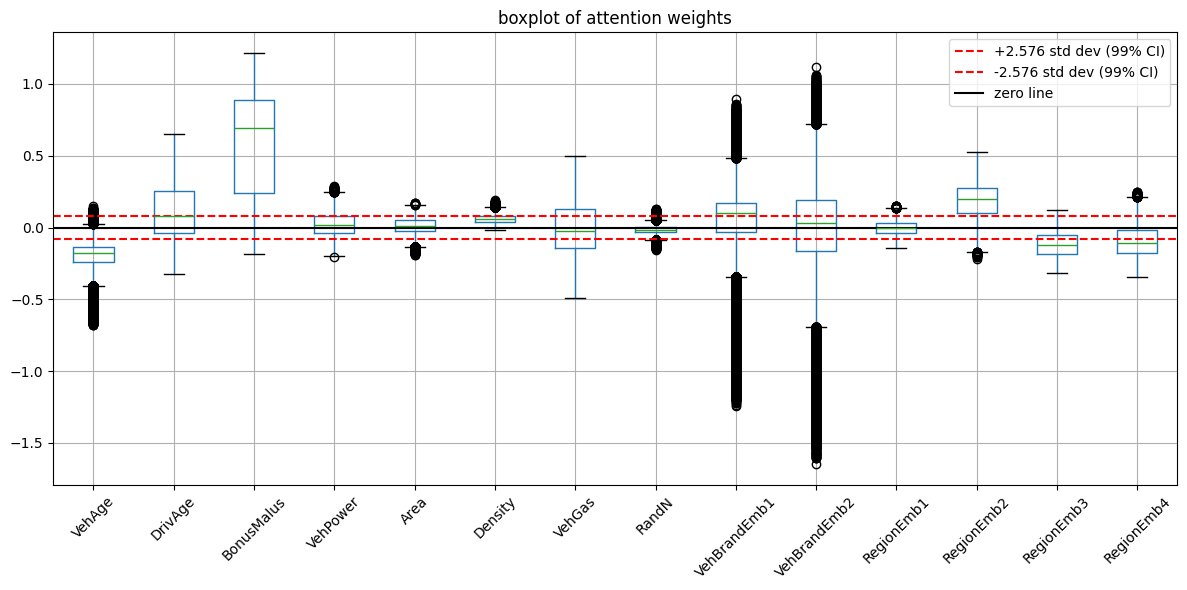

In [47]:
randnx_std = emb_attention_df["RandN"].std()
threshold = 2.576 * randnx_std

# Plot attention weights
plt.figure(figsize=(12, 6))
emb_attention_df.boxplot()
plt.xticks(rotation=45)
plt.title("boxplot of attention weights")
plt.axhline(y=threshold, color="r", linestyle="--", label="+2.576 std dev (99% CI)")
plt.axhline(y=-threshold, color="r", linestyle="--", label="-2.576 std dev (99% CI)")
plt.axhline(y=0, color="k", linestyle="-", label="zero line")
plt.legend()
plt.tight_layout()
plt.show()

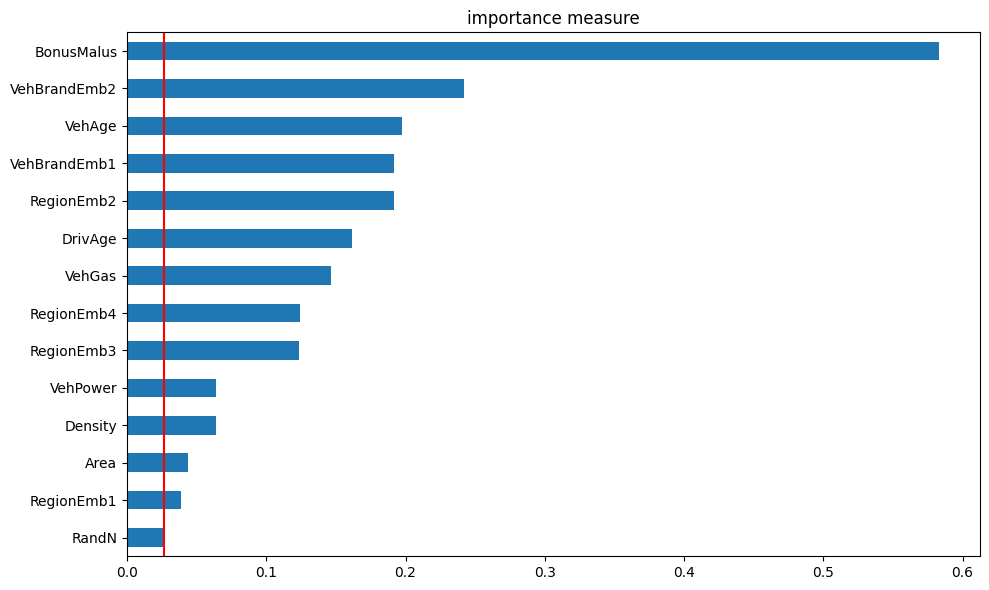

In [48]:
vi = np.abs(emb_attention_df).mean()
vi = vi.sort_values()

# Plot importance measure
plt.figure(figsize=(10, 6))
vi.plot(kind="barh")
# Add vertical line for AreaX importance
area_importance = vi["RandN"]
plt.axvline(x=area_importance, color="red", linestyle="-", label="RandN importance")
plt.title("importance measure")
plt.tight_layout()
plt.show()

/Users/sanghuynh/miniconda3/envs/AutoQuant/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/sanghuynh/miniconda3/envs/AutoQuant/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


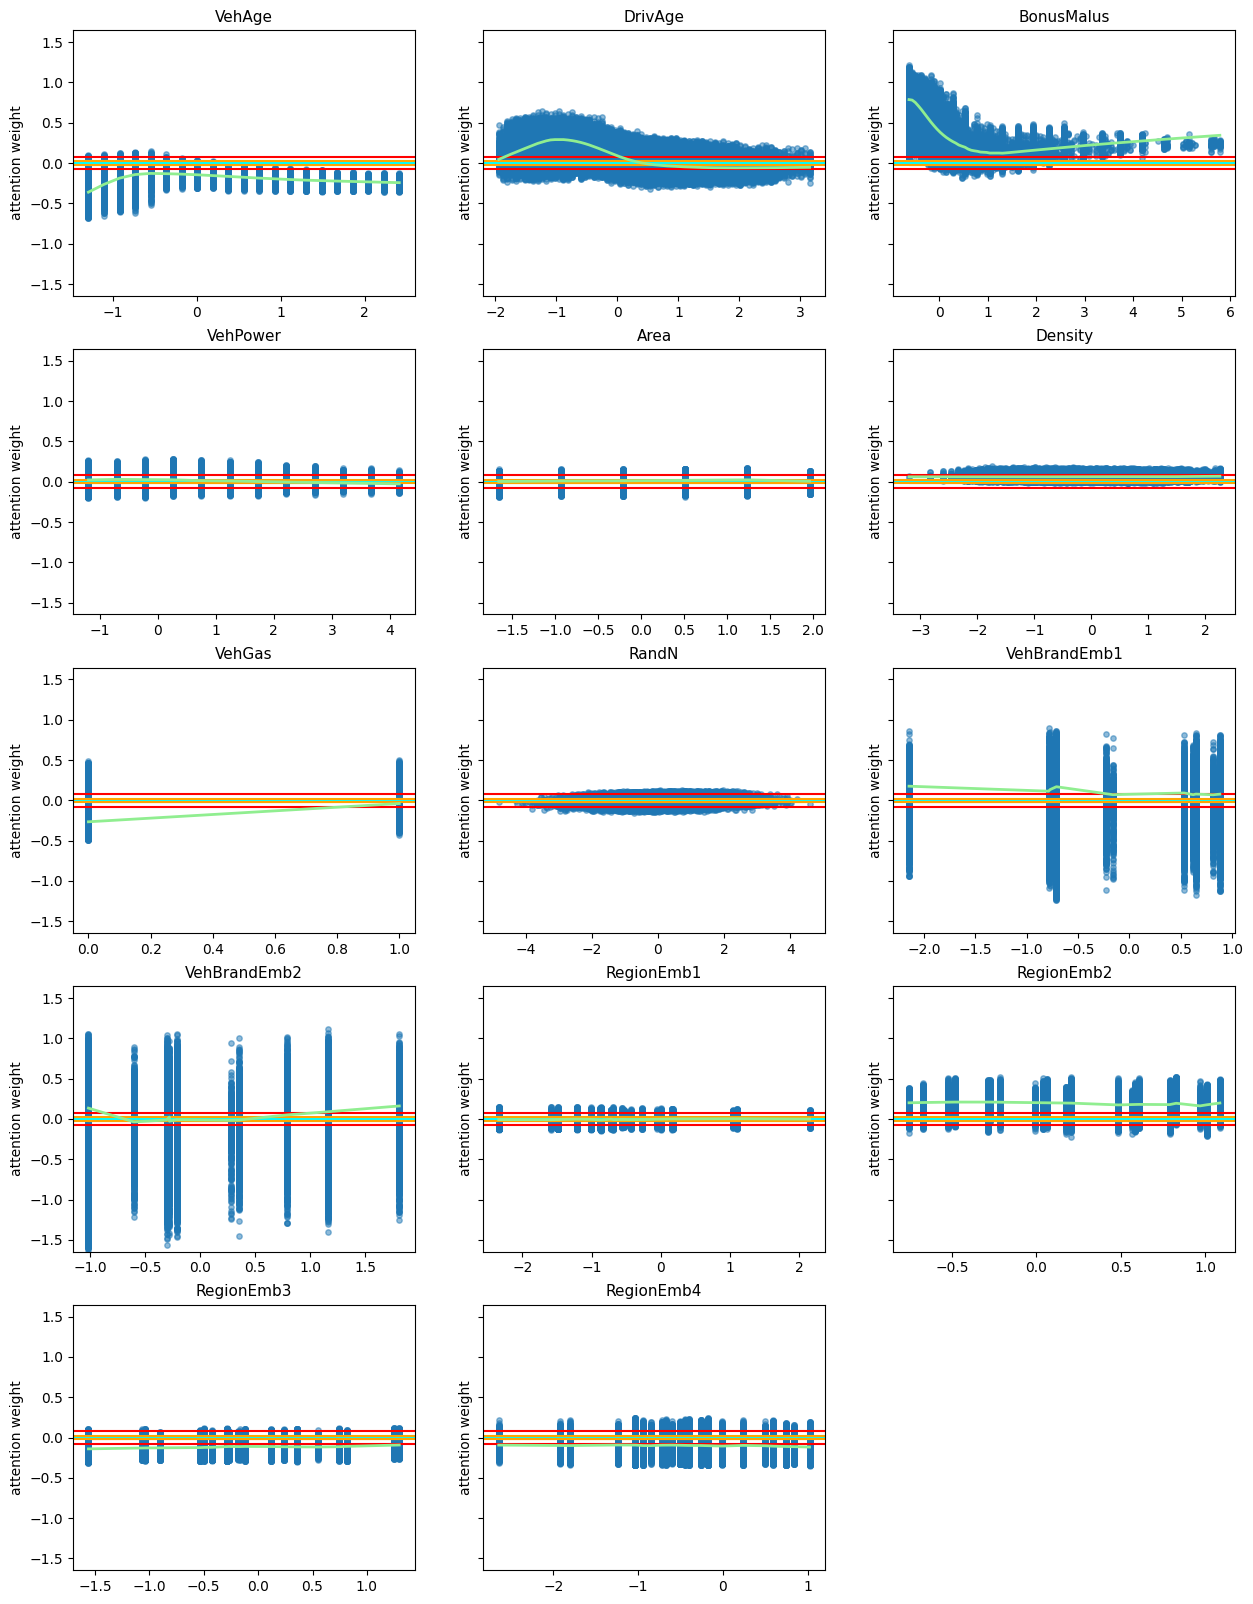

In [49]:
n_features = len(cols)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 4 * n_rows),
    sharey=True
)

axes = axes.flatten()

for i, feature_name in enumerate(cols):
    ax = axes[i]

    if feature_name == "RandN":
        plot_attention_weights(feature_name, 0.3, X_test_emb, ax, emb_attention_df,loess=False)
    else:
        plot_attention_weights(feature_name, 0.3, X_test_emb, ax, emb_attention_df)

# Xóa các subplot thừa (nếu có)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])



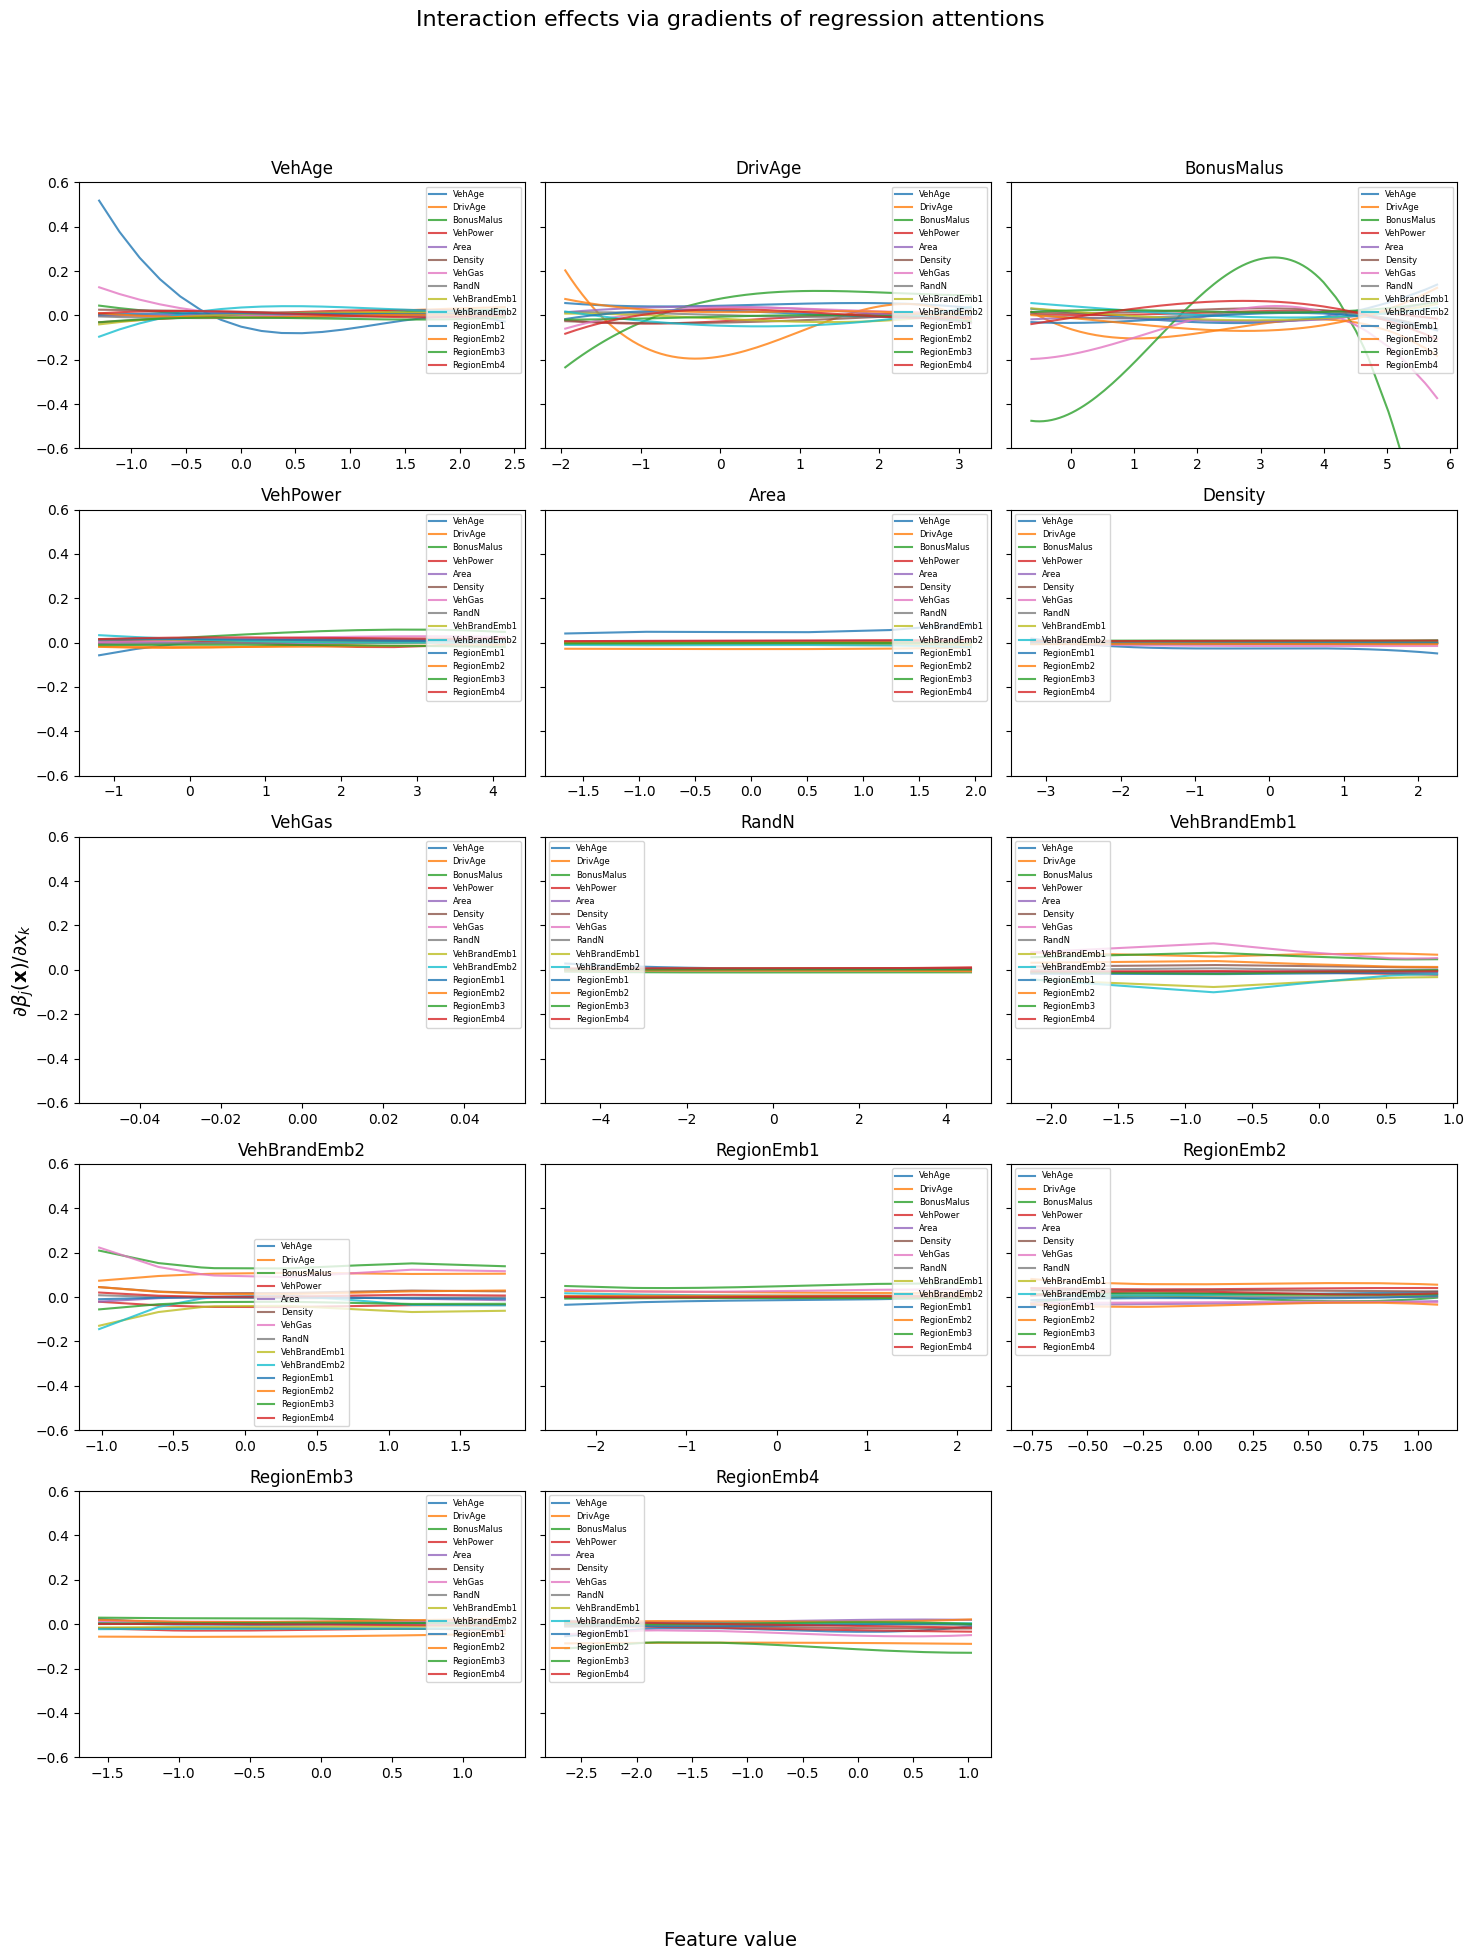

In [50]:
n, p = X_test_emb.shape
gradients = np.empty((p, n, p))
input_tensor = X_test_emb_tensor

input_tensor.requires_grad = True
attentions = model_emb(X_test_emb_tensor, v_test_tensor, get_attentions=True)
for i in range(p):
    grad_scaling = torch.ones_like(attentions[:, i])
    gradient_i = autograd.grad(
        attentions[:, i], input_tensor, grad_scaling, create_graph=True
    )
    gradients[i, :, :] = gradient_i[0].numpy(force=True)


vars_x = cols
n_plots = len(vars_x)

n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 4 * n_rows),
    sharey=True
)

axes = axes.flatten()
for i, var_x in enumerate(vars_x):
    ax = axes[i]
    var_x_idx = emb_attention_df.columns.get_loc(var_x)

    for derivative_wrt in emb_attention_df.columns:
        idx_var_derivative = emb_attention_df.columns.get_loc(derivative_wrt)

        x = X_test_emb[var_x].values
        y_data = gradients[var_x_idx, :, idx_var_derivative]

        # sort
        sort_idx = np.argsort(x)
        x_sorted = x[sort_idx]
        y_sorted = y_data[sort_idx]

        # spline smoothing
        spline = UnivariateSpline(x_sorted, y_sorted, k=3, s=None)
        kk = np.sort(x)
        spline0 = spline(kk)

        ax.plot(kk, spline0, alpha=0.8, linewidth=1.5, label=derivative_wrt)

    ax.set_title(var_x, fontsize=12)
    ax.set_ylim([-0.6, 0.6])
    ax.legend(fontsize=6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.supxlabel("Feature value", fontsize=14)
fig.supylabel(r"$\partial \beta_j(\mathbf{x}) / \partial x_k$", fontsize=14)

fig.suptitle("Interaction effects via gradients of regression attentions", fontsize=16)

fig.tight_layout(rect=[0, 0.07, 1, 0.93])
plt.show()

In [62]:
class LocalGLMNetEmbedding(nn.Module):
    def __init__(self, seed, n_features, hidden_layers,
                 kk, bb, intercept=None, glm_coefs=None):
        super().__init__()
        torch.manual_seed(seed)

        # ---- Categorical embeddings ----
        self.brand_embed = nn.Embedding(kk[0], bb[0])
        self.region_embed = nn.Embedding(kk[1], bb[1])

        self.cat_dim = bb[0] + bb[1]

        # ---- Continuous feature count ----
        n_cont = n_features - 2

        # ---- MLP after transformer ----
        mlp_input_dim = n_cont + self.cat_dim

        self.hidden_layers = nn.ModuleList()

        for i in range(len(hidden_layers)):
            if i == 0:
                self.hidden_layers.append(nn.Linear(mlp_input_dim, hidden_layers[i]))
            else:
                self.hidden_layers.append(
                    nn.Linear(hidden_layers[i - 1], hidden_layers[i])
                )

        # Local GLM head: learns coefficients from scratch
        self.local_glm = nn.Linear(hidden_layers[-1], mlp_input_dim)
        init.constant_(self.local_glm.weight, 0.0)
        if glm_coefs is not None:
            self.local_glm.bias.data = torch.tensor(glm_coefs, dtype=torch.float32)
        else:
            init.constant_(self.local_glm.bias, 0.0)
        if intercept is not None:
            self.intercept = nn.Parameter(torch.tensor(intercept, dtype=torch.float32))
        else:
            self.intercept = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))


    def forward(self, x, v, get_attentions=False):
        # ------------ Prepare feature -------------
        brand_emb = self.brand_embed(x[:, -3].long())
        region_emb = self.region_embed(x[:, -2].long())
        cont_x = torch.cat((x[:, :-3], x[:, -1:]), dim=1)

        x = torch.cat([cont_x, brand_emb, region_emb], dim=1)

        z = torch.tanh(self.hidden_layers[0](x))
        for layer in self.hidden_layers[1:]:
            z = torch.tanh(layer(z))
        z = self.local_glm(z)
        if get_attentions:
            return z
        skip_connection = torch.einsum("ij,ij->i", z, x).unsqueeze(1)
        z = self.intercept + skip_connection
        return torch.exp(z).flatten() * v

In [63]:
SEED = 1234
M_FEAT = X_train.shape[1]
HIDDEN = [64, 48, 32, 16]
mu_hom = y_train.sum() / v_train.sum()  # homogeneous frequency
KK = [len(X_train['VehBrand'].unique()), len(X_train['Region'].unique())]  # number of categories
BB = [2, 4]  # embedding dimensions

model_self_emb = LocalGLMNetEmbedding(
    seed=SEED,
    n_features=M_FEAT,
    hidden_layers=HIDDEN,
    kk=KK,
    bb=BB,
    intercept=glm_results_num.params['Intercept'],
    glm_coefs=np.concatenate([glm_results_num.params[1:].values, np.zeros(BB[0] + BB[1])])
)

model_self_emb.to(device)

LocalGLMNetEmbedding(
  (brand_embed): Embedding(11, 2)
  (region_embed): Embedding(22, 4)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=48, bias=True)
    (2): Linear(in_features=48, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (local_glm): Linear(in_features=16, out_features=14, bias=True)
)

In [ ]:
history = train_model(
    model_self_emb, train_loader, val_loader,
    torch.optim.NAdam(model_self_emb.parameters(), lr=1e-3),
    checkpoint_path=f"./ModelSelfEmb_PyTorch_{SEED}.pt",
    n_epochs=100,
    device=device
)

Epoch 10/100, Loss: 0.3835, Val Loss: 0.3847
Epoch 20/100, Loss: 0.3816, Val Loss: 0.3841
Epoch 30/100, Loss: 0.3801, Val Loss: 0.3843
Epoch 40/100, Loss: 0.3786, Val Loss: 0.3851
Epoch 50/100, Loss: 0.3769, Val Loss: 0.3861
Epoch 60/100, Loss: 0.3750, Val Loss: 0.3871
Epoch 70/100, Loss: 0.3731, Val Loss: 0.3884
Epoch 80/100, Loss: 0.3712, Val Loss: 0.3899
Epoch 90/100, Loss: 0.3693, Val Loss: 0.3917
Epoch 100/100, Loss: 0.3674, Val Loss: 0.3935


{'loss': [0.39416533688496824,
  0.3914077172413834,
  0.38739805119144766,
  0.38601156768010436,
  0.3853880376350654,
  0.3849278628416028,
  0.3845191497372302,
  0.38414137525571984,
  0.38380460520674925,
  0.3835172960139127,
  0.38326959996696636,
  0.3830495140200847,
  0.3828491281072985,
  0.38266131113481705,
  0.38247974948690827,
  0.38230089066786344,
  0.38212449652679953,
  0.381951073389422,
  0.3817811827495382,
  0.3816151441527184,
  0.38145270567823514,
  0.3812925564226813,
  0.3811342324345641,
  0.38097867054242573,
  0.3808263882865873,
  0.38067711349968114,
  0.38053028990482557,
  0.3803864012742821,
  0.38024474075011006,
  0.3801024441513871,
  0.3799583873725859,
  0.37981133815456697,
  0.3796599587640197,
  0.37950859433220835,
  0.37935699895384,
  0.3792040330145676,
  0.379049411517645,
  0.3788945502728214,
  0.3787407050863805,
  0.3785860899597855,
  0.3784291951608801,
  0.37827048348775516,
  0.37811050420815745,
  0.3779480166697302,
  0.37778

In [68]:
model_self_emb.load_state_dict(torch.load(f'./ModelSelfEmb_PyTorch_{SEED}.pt'))

poisson_deviance_train_glmnet_self = score(model_self_emb, X=X_train_tensor, v=v_train_tensor, y=y_train_tensor)
poisson_deviance_test_glmnet_self = score(model_self_emb, X=X_test_tensor, v=v_test_tensor, y=y_test_tensor)

print(f"Poisson Deviance in LocalGLMNet with self-trained embeddings (Train): {poisson_deviance_train_glmnet_self:.3f}")
print(f"Poisson Deviance in LocalGLMNet with self-trained embeddings (Test): {poisson_deviance_test_glmnet_self:.3f}")

Poisson Deviance in LocalGLMNet with self-trained embeddings (Train): 57.687
Poisson Deviance in LocalGLMNet with self-trained embeddings (Test): 58.877


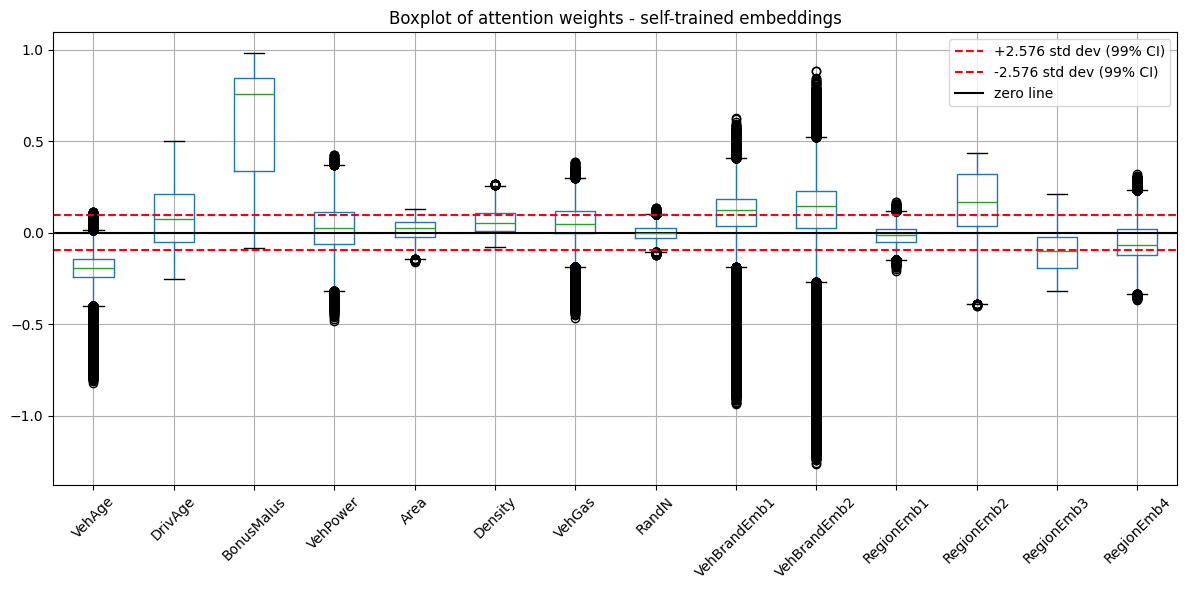

In [72]:
self_emb_attention_weights = model_self_emb(X_test_tensor, v_test_tensor, get_attentions=True).cpu().detach().numpy()
self_emb_attention_df = pd.DataFrame(self_emb_attention_weights, columns=cols)
randnx_std = self_emb_attention_df["RandN"].std()
threshold = 2.576 * randnx_std

# Plot attention weights
plt.figure(figsize=(12, 6))
self_emb_attention_df.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of attention weights - self-trained embeddings")
plt.axhline(y=threshold, color="r", linestyle="--", label="+2.576 std dev (99% CI)")
plt.axhline(y=-threshold, color="r", linestyle="--", label="-2.576 std dev (99% CI)")
plt.axhline(y=0, color="k", linestyle="-", label="zero line")
plt.legend()
plt.tight_layout()
plt.show()

In [98]:
X_train_raw 

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,RandN
1861,3877.0,0.34,B,5,1,46,50,B12,Regular,59,R93,-1.084611
322420,2255565.0,0.49,C,4,1,41,60,B3,Diesel,107,R93,-1.506782
296697,2203915.0,1.00,A,10,1,41,50,B13,Diesel,13,R24,1.177551
86328,177468.0,0.03,C,4,15,23,100,B2,Regular,405,R24,-1.158789
204678,2010506.0,0.24,D,7,7,36,60,B12,Regular,949,R24,-0.031337
...,...,...,...,...,...,...,...,...,...,...,...,...
84717,174565.0,0.58,B,4,15,53,50,B1,Regular,58,R53,0.422074
585887,4177065.0,0.46,A,5,12,41,50,B4,Diesel,19,R24,0.046241
661165,6084605.0,0.28,E,8,3,41,50,B12,Regular,4128,R52,1.326314
127956,1081038.0,1.00,C,7,10,60,50,B2,Regular,126,R24,-1.713588


In [102]:
onehot_preprocessor = ColumnTransformer(
    transformers=[
        (
            "scale",
            clip_and_scale([20, 90, 150, 15]),
            ["VehAge", "DrivAge", "BonusMalus", "VehPower"],
        ),
        ("area", area_pipeline, ["Area"]),
        ("density", density_pipeline, ["Density"]),
        (
            "veh_gas",
            FunctionTransformer(lambda x: (x == "Diesel").astype(np.float32)),
            ["VehGas"],
        ),
        # CHANGE: Use OneHotEncoder instead of OrdinalEncoder
        # sparse_output=False is required for PyTorch tensor conversion
        # handle_unknown='ignore' is safer for production/test sets
        (
            "cat_onehot", 
            OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
            ["VehBrand", "Region"]
        ),
        ("passthrough", "passthrough", ["RandN"]),
    ],
    verbose_feature_names_out=False,
)

In [105]:
onehot_preprocessor.set_output(transform="pandas").fit(X_train_raw)

X_train_cat = onehot_preprocessor.transform(X_train_raw)
X_val_cat = onehot_preprocessor.transform(X_val_raw)
X_test_cat = onehot_preprocessor.transform(X_test_raw)

print(X_train_cat.columns)
X_train_cat

Index(['VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'Area', 'Density',
       'VehGas', 'VehBrand_B1', 'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12',
       'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3',
       'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6', 'Region_R11', 'Region_R21',
       'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26',
       'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52',
       'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74',
       'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94',
       'RandN'],
      dtype='object')


,VehAge,DrivAge,BonusMalus,VehPower,Area,Density,VehGas,VehBrand_B1,VehBrand_B10,VehBrand_B11,...,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94,RandN
1861,-1.107974,0.036073,-0.625056,-0.707794,-0.934227,-1.017452,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.084611
322420,-1.107974,-0.317979,0.016469,-1.194693,-0.210642,-0.701998,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.506782
296697,-1.107974,-0.317979,-0.625056,1.726705,-1.657812,-1.830145,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.177551
86328,1.485777,-1.592566,2.582572,-1.194693,-0.210642,0.009109,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.158789
204678,0.003633,-0.672031,0.016469,0.266006,0.512943,0.468923,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.031337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84717,1.485777,0.531745,-0.625056,-1.194693,-0.934227,-1.028145,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.422074
585887,0.929973,-0.317979,-0.625056,-0.707794,-1.657812,-1.626972,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046241
661165,-0.737438,-0.317979,-0.625056,0.752905,1.236529,1.254883,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.326314
127956,0.559437,1.027418,-0.625056,0.266006,-0.210642,-0.611105,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.713588


In [107]:
X_train_cat_tensor = torch.tensor(X_train_cat.values, dtype=torch.float32, device=device)
X_val_cat_tensor = torch.tensor(X_val_cat.values, dtype=torch.float32, device=device)
X_test_cat_tensor = torch.tensor(X_test_cat.values, dtype=torch.float32, device=device)

In [106]:
glm_features = [f for f in X_train_cat.columns if f not in ['VehBrand_B1', 'Region_R11']]

formula = "ClaimNb ~ " + " + ".join(glm_features)

glm_cat = glm(
    formula=formula,
    data=pd.concat([X_train_cat, y_train], axis=1), # Use the transformed data
    family=sm.families.Poisson(),
    exposure=v_train
)
glm_results_cat = glm_cat.fit()
glm_results_cat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               406807
Model:                            GLM   Df Residuals:                   406767
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85824.
Date:                Tue, 06 Jan 2026   Deviance:                   1.3014e+05
Time:                        22:54:40   Pearson chi2:                 1.10e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01044
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.3695      0.028    -83.770      0.000      -2.425      -2.314
VehAge          -0.2247      0.008    -26.979      0.000      -0.241      -0.208
DrivAge          0.0931      0.007     12.861      0.000       0.079       0.107
BonusMalus       0.3509      0.006     54.997      0.000       0.338       0.363
VehPower         0.0282      0.007      3.855      0.000       0.014       0.043
Area             0.0101      0.029      0.350      0.726      -0.046       0.067
Density          0.0747      0.029      2.570      0.010       0.018       0.132
VehGas          -0.0457      0.014     -3.234      0.001      -0.073      -0.018
VehBrand_B10    -0.0110      0.047     -0.232      0.816      -0.104       0.082
VehBrand_B11     0.0553      0.052      1.074      0.283      -0.046       0.156
VehBrand_B12     0.1268      0.023      5.621      0.000       0.083       0.171
VehBrand_B13     0.0307      0.052      0.589      0.556      -0.071       0.133
VehBrand_B14    -0.1408      0.099     -1.421      0.155      -0.335       0.053
VehBrand_B2     -0.0270      0.020     -1.371      0.170      -0.066       0.012
VehBrand_B3     -0.0167      0.028     -0.593      0.553      -0.072       0.039
VehBrand_B4     -0.0503      0.039     -1.306      0.192      -0.126       0.025
VehBrand_B5      0.0694      0.032      2.178      0.029       0.007       0.132
VehBrand_B6     -0.1038      0.037     -2.772      0.006      -0.177      -0.030
Region_R21       0.0936      0.109      0.856      0.392      -0.121       0.308
Region_R22       0.1131      0.066      1.720      0.085      -0.016       0.242
Region_R23       0.0428      0.076      0.565      0.572      -0.106       0.191
Region_R24       0.1034      0.030      3.420      0.001       0.044       0.163
Region_R25       0.0838      0.056      1.498      0.134      -0.026       0.193
Region_R26       0.0512      0.062      0.827      0.408      -0.070       0.173
Region_R31      -0.0194      0.043     -0.450      0.653      -0.104       0.065
Region_R41      -0.1424      0.056     -2.527      0.011      -0.253      -0.032
Region_R42      -0.0094      0.117     -0.080      0.936      -0.238       0.220
Region_R43       0.0279      0.168      0.166      0.868      -0.302       0.358
Region_R52       0.0376      0.038      1.003      0.316      -0.036       0.111
Region_R53       0.1106      0.035      3.125      0.002       0.041       0.180
Region_R54       0.0296      0.048      0.611      0.541      -0.065       0.124
Region_R72      -0.0382      0.042     -0.908      0.364      -0.121       0.044
Region_R73      -0.1077      0.055     -1.964      0.049      -0.215      -0.000
Region_R74       0.1721      0.086      1.999      0.046       0.003       0.341
Region_R82       0.1215      0.029      4.199      0.000       0.065       0.178
Regio

In [112]:
glm_coefs_cat = []
for i, col in enumerate(X_train_cat.columns):
    if col not in glm_results_cat.params:
        glm_coefs_cat.append(0)
    else:
        glm_coefs_cat.append(glm_results_cat.params[col])
print(glm_coefs_cat)

[-0.22465839525324763, 0.09308673981790917, 0.35091770826557334, 0.028197459475132806, 0.010099356912350019, 0.07470077856863994, -0.045746746881386365, 0, -0.011000441553290321, 0.05530777066640642, 0.1268318907516509, 0.03069895764598492, -0.14084520846155837, -0.02704164013609827, -0.016737786191920265, -0.050282046009062324, 0.0693859337972835, -0.1037507535891146, 0, 0.09364586368991835, 0.1131174807961861, 0.04276419753546047, 0.10336071398511035, 0.08381344036589074, 0.051218666882696474, -0.019435626243405463, -0.14241895069343866, -0.009381276330488724, 0.0279277633150069, 0.0376413879676025, 0.11057869310146509, 0.02957039404770776, -0.03824853999862076, -0.10774730370743832, 0.1721284283147981, 0.1215123838399386, -0.3118942632572534, 0.04025171600364442, 0.033436229790236555, 0.1894163510783426, 0.0036482312710331855]


In [113]:
model_cat = LocalGLMNet(
    seed=SEED,
    n_features=X_train_cat.shape[1],
    hidden_layers=HIDDEN,
    intercept=glm_results_cat.params['Intercept'],
    glm_coefs=np.array(glm_coefs_cat)
)
model_cat.to(device)

LocalGLMNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=48, bias=True)
    (2): Linear(in_features=48, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
  )
  (local_glm): Linear(in_features=16, out_features=41, bias=True)
)

In [114]:
# Prepare DataLoader instances
train_cat_dataset = TensorDataset(X_train_cat_tensor, v_train_tensor, y_train_tensor)
val_cat_dataset = TensorDataset(X_val_cat_tensor, v_val_tensor, y_val_tensor)
test_cat_dataset = TensorDataset(X_test_cat_tensor, v_test_tensor, y_test_tensor)
train_cat_loader = DataLoader(train_cat_dataset, batch_size=batch_size, shuffle=False)
val_cat_loader = DataLoader(val_cat_dataset, batch_size=batch_size, shuffle=False)
test_cat_loader = DataLoader(test_cat_dataset, batch_size=batch_size, shuffle=False)

In [115]:
train_model(
    model_cat, train_cat_loader, val_cat_loader,
    torch.optim.NAdam(model_cat.parameters(), lr=1e-3),
    checkpoint_path=f"./ModelCat_PyTorch_{SEED}.pt",
    n_epochs=100,
    device=device
)

Epoch 10/100, Loss: 0.3837, Val Loss: 0.3859
Epoch 20/100, Loss: 0.3816, Val Loss: 0.3849
Epoch 30/100, Loss: 0.3797, Val Loss: 0.3852
Epoch 40/100, Loss: 0.3776, Val Loss: 0.3857
Epoch 50/100, Loss: 0.3752, Val Loss: 0.3869
Epoch 60/100, Loss: 0.3727, Val Loss: 0.3885
Epoch 70/100, Loss: 0.3702, Val Loss: 0.3904
Epoch 80/100, Loss: 0.3676, Val Loss: 0.3931
Epoch 90/100, Loss: 0.3651, Val Loss: 0.3953
Epoch 100/100, Loss: 0.3628, Val Loss: 0.3975


{'loss': [0.3930591189715162,
  0.3880584802501739,
  0.38596128001222835,
  0.3853822554182224,
  0.38503546283876366,
  0.3847474991346898,
  0.384476426895507,
  0.38421294038566883,
  0.38395263479866953,
  0.3836887045130002,
  0.3834112814830536,
  0.3831253885080932,
  0.38285463703886113,
  0.382612937989943,
  0.3824058955993906,
  0.38222626730155235,
  0.3820652282230215,
  0.3818914899407457,
  0.38172308600046867,
  0.3815706254996694,
  0.381416832251805,
  0.3812441011023554,
  0.38107059644607794,
  0.38089237274337323,
  0.38070373160310195,
  0.38049075558064926,
  0.38027946185702716,
  0.3800709856813999,
  0.37988468860875635,
  0.37966002102997964,
  0.37945403669938516,
  0.3792700884854235,
  0.3790408537011482,
  0.37883436664701126,
  0.378642625357526,
  0.37843631922779125,
  0.37823637618585937,
  0.37802383614933865,
  0.37780640524499143,
  0.3775785040595243,
  0.377342846636417,
  0.3771089248525436,
  0.3768692247201599,
  0.37661787329405194,
  0.3763

In [116]:
# Reload the best model
model_cat.load_state_dict(torch.load(f'./ModelCat_PyTorch_{SEED}.pt'))
poisson_deviance_train_glmnet_cat = score(model_cat, X=X_train_cat_tensor, v=v_train_tensor, y=y_train_tensor)
poisson_deviance_test_glmnet_cat = score(model_cat, X=X_test_cat_tensor, v=v_test_tensor, y=y_test_tensor)

print(f"Poisson Deviance in LocalGLMNet with one-hot encoded categorical features (Train): {poisson_deviance_train_glmnet_cat:.3f}")
print(f"Poisson Deviance in LocalGLMNet with one-hot encoded categorical features (Test): {poisson_deviance_test_glmnet_cat:.3f}")

Poisson Deviance in LocalGLMNet with one-hot encoded categorical features (Train): 57.715
Poisson Deviance in LocalGLMNet with one-hot encoded categorical features (Test): 58.986


In [118]:
cat_attention_weights = model_cat(X_test_cat_tensor, v_test_tensor, get_attentions=True).cpu().detach().numpy()
cat_attention_df = pd.DataFrame(cat_attention_weights, columns=X_test_cat.columns)
randnx_std = cat_attention_df["RandN"].std()
threshold = 2.576 * randnx_std

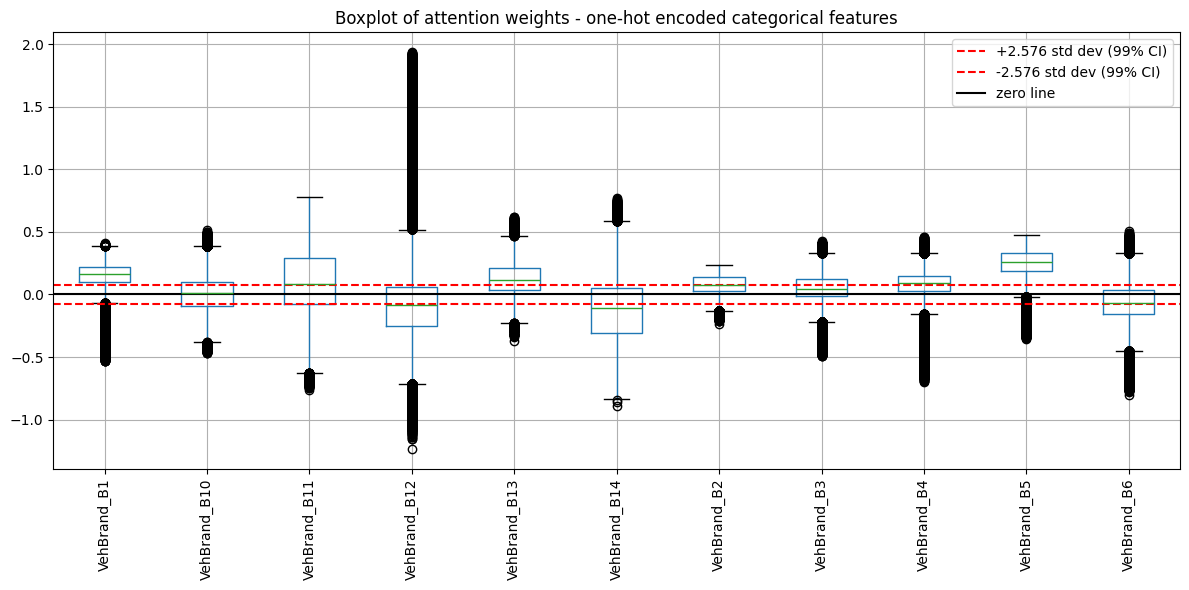

In [119]:
# Plot attention weights for vehbrand one-hot features
plt.figure(figsize=(12, 6))
cat_attention_df.filter(like='VehBrand_').boxplot()
plt.xticks(rotation=90)
plt.title("Boxplot of attention weights - one-hot encoded categorical features")
plt.axhline(y=threshold, color="r", linestyle="--", label="+2.576 std dev (99% CI)")
plt.axhline(y=-threshold, color="r", linestyle="--", label="-2.576 std dev (99% CI)")
plt.axhline(y=0, color="k", linestyle="-", label="zero line")
plt.legend()
plt.tight_layout()
plt.show()

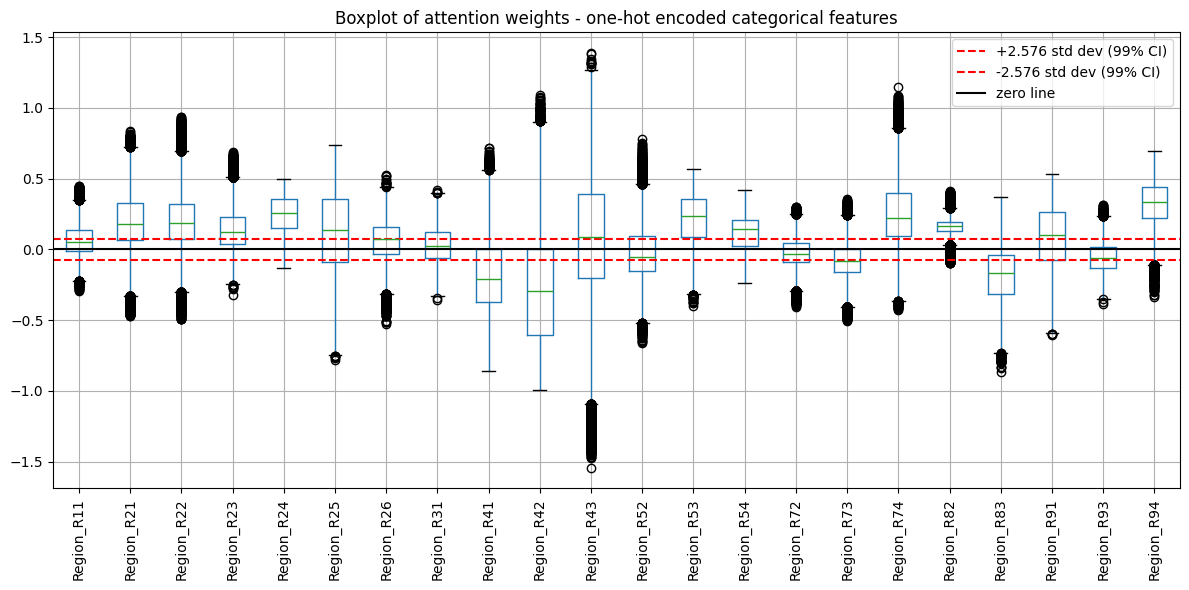

In [120]:
# Plot attention weights for vehbrand one-hot features
plt.figure(figsize=(12, 6))
cat_attention_df.filter(like='Region_').boxplot()
plt.xticks(rotation=90)
plt.title("Boxplot of attention weights - one-hot encoded categorical features")
plt.axhline(y=threshold, color="r", linestyle="--", label="+2.576 std dev (99% CI)")
plt.axhline(y=-threshold, color="r", linestyle="--", label="-2.576 std dev (99% CI)")
plt.axhline(y=0, color="k", linestyle="-", label="zero line")
plt.legend()
plt.tight_layout()
plt.show()

## Performance evaluation

In [121]:
# Null model: GLM with intercept only
glm_null = glm(
    formula='ClaimNb ~ 1',
    data=pd.concat([X_train, y_train], axis=1),
    family=sm.families.Poisson(),
    exposure=v_train
)
glm_results_null = glm_null.fit()
print(glm_results_null.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               406807
Model:                            GLM   Df Residuals:                   406806
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87959.
Date:                Tue, 06 Jan 2026   Deviance:                   1.3441e+05
Time:                        23:37:16   Pearson chi2:                 1.20e+06
No. Iterations:                     7   Pseudo R-squ. (CS):          1.110e-16
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2980      0.007   -337.709      0.0

In [122]:
# score of null model
poisson_deviance_train_null = 100 * mean_poisson_deviance(
    y_train.values / v_train.values,
    glm_results_null.predict(X_train, exposure=v_train),
    sample_weight=v_train.values
)
poisson_deviance_test_null = 100 * mean_poisson_deviance(
    y_test.values / v_test.values,
    glm_results_null.predict(X_test, exposure=v_test),
    sample_weight=v_test.values
)
print(f"Poisson Deviance in Null Model (Train): {poisson_deviance_train_null:.3f}")
print(f"Poisson Deviance in Null Model (Test): {poisson_deviance_test_null:.3f}")

Poisson Deviance in Null Model (Train): 72.827
Poisson Deviance in Null Model (Test): 73.074


In [136]:
glm_null_pred_train = glm_results_null.predict(X_train, exposure=v_train).values
glm_num_pred_train = glm_results_num.predict(X_train_num, exposure=v_train).values
glm_emb_pred_train = glm_results_emb.predict(X_train_emb, exposure=v_train).values
glm_cat_pred_train = glm_results_cat.predict(X_train_cat, exposure=v_train).values

glmnet_num_pred_train = model_num(X_train_num_tensor, v_train_tensor).cpu().detach().numpy()
glmnet_cat_pred_train = model_cat(X_train_cat_tensor, v_train_tensor).cpu().detach().numpy()
glmnet_self_emb_pred_train = model_self_emb(X_train_tensor, v_train_tensor).cpu().detach().numpy()
glmnet_emb_pred_train = model_emb(X_train_emb_tensor, v_train_tensor).cpu().detach().numpy()
fnn_pred_train = model_fnn(X_train_tensor, v_train_tensor).cpu().detach().numpy()

results_df_train = pd.DataFrame({
    'GLM_Null': glm_null_pred_train,
    'GLM_Num': glm_num_pred_train,
    'GLM_Emb': glm_emb_pred_train,
    'GLM_Cat': glm_cat_pred_train,
    'GLMNet_Num': glmnet_num_pred_train,
    'GLMNet_Emb': glmnet_emb_pred_train,
    'GLMNet_Cat': glmnet_cat_pred_train,
    'GLMNet_SelfEmb': glmnet_self_emb_pred_train,
    'FNN': fnn_pred_train
})

In [ ]:
glm_null_pred_test = glm_results_null.predict(X_test, exposure=v_test).values
glm_num_pred_test = glm_results_num.predict(X_test_num, exposure=v_test).values
glm_emb_pred_test = glm_results_emb.predict(X_test_emb, exposure=v_test).values
glm_cat_pred_test = glm_results_cat.predict(X_test_cat, exposure=v_test).values

glmnet_num_pred_test = model_num(X_test_num_tensor, v_test_tensor).cpu().detach().numpy()
glmnet_cat_pred_test = model_cat(X_test_cat_tensor, v_test_tensor).cpu().detach().numpy()
glmnet_self_emb_pred_test = model_self_emb(X_test_tensor, v_test_tensor).cpu().detach().numpy()
glmnet_emb_pred_test = model_emb(X_test_emb_tensor, v_test_tensor).cpu().detach().numpy()
fnn_pred_test = model_fnn(X_test_tensor, v_test_tensor).cpu().detach().numpy()

results_df_test = pd.DataFrame({
    'GLM_Null': glm_null_pred_test,
    'GLM_Num': glm_num_pred_test,
    'GLM_Emb': glm_emb_pred_test,
    'GLM_Cat': glm_cat_pred_test,
    'GLMNet_Num': glmnet_num_pred_test,
    'GLMNet_Emb': glmnet_emb_pred_test,
    'GLMNet_Cat': glmnet_cat_pred_test,
    'GLMNet_SelfEmb': glmnet_self_emb_pred_test,
    'FNN': fnn_pred_test
})

In [137]:
for col in results_df_train.columns:
    poisson_deviance = 100 * mean_poisson_deviance(
        y_train.values / v_train.values,
        results_df_train[col].values,
        sample_weight=v_train.values
    )
    print(f"Poisson Deviance in {col} (Train): {poisson_deviance:.3f}") 

Poisson Deviance in GLM_Null (Train): 72.827
Poisson Deviance in GLM_Num (Train): 70.296
Poisson Deviance in GLM_Emb (Train): 70.222
Poisson Deviance in GLM_Cat (Train): 70.194
Poisson Deviance in GLMNet_Num (Train): 67.363
Poisson Deviance in GLMNet_Emb (Train): 66.658
Poisson Deviance in GLMNet_Cat (Train): 66.953
Poisson Deviance in GLMNet_SelfEmb (Train): 66.782
Poisson Deviance in FNN (Train): 66.953


In [ ]:
for col in results_df_test.columns:
    poisson_deviance = 100 * mean_poisson_deviance(
        y_test.values / v_test.values,
        results_df_test[col].values,
        sample_weight=v_test.values
    )
    print(f"Poisson Deviance in {col} (Test): {poisson_deviance:.3f}") 

Poisson Deviance in GLM_Null (Test): 73.074
Poisson Deviance in GLM_Num (Test): 70.746
Poisson Deviance in GLM_Emb (Test): 70.652
Poisson Deviance in GLM_Cat (Test): 70.637
Poisson Deviance in GLMNet_Num (Test): 68.366
Poisson Deviance in GLMNet_Emb (Test): 68.009
Poisson Deviance in GLMNet_Cat (Test): 68.230
Poisson Deviance in GLMNet_SelfEmb (Test): 67.974
Poisson Deviance in FNN (Test): 68.145


In [131]:
def multiple_lift(y_true, exposure, y_pred_df, tiles=10):
    """
    Multiple Lift Chart for Predicted Frequency with Lift metrics in Legend.
    """
    plot_data_list = []
    
    for model_name in y_pred_df.columns:
        # 1. Prepare Data
        temp_df = pd.DataFrame({
            'actual': y_true,
            'exposure': exposure,
            'pred_count': y_pred_df[model_name]
        })
        
        # Predicted Frequency
        temp_df['pred_freq'] = temp_df['pred_count'] / temp_df['exposure']
        
        # 2. Sort by Predicted Frequency
        temp_df = temp_df.sort_values('pred_freq').reset_index(drop=True)
        
        # 3. Create tiles based on equal EXPOSURE
        temp_df['cum_exposure'] = temp_df['exposure'].cumsum()
        total_exp = temp_df['exposure'].sum()
        boundaries = np.linspace(0, total_exp, tiles + 1)
        temp_df['tile'] = pd.cut(temp_df['cum_exposure'], 
                                 bins=boundaries, 
                                 labels=range(1, tiles + 1), 
                                 include_lowest=True)
        
        # 4. Calculate Weighted Predicted Frequency per Tile
        tile_stats = temp_df.groupby('tile', observed=True).agg({
            'pred_count': 'sum',
            'exposure': 'sum'
        }).reset_index()
        
        tile_stats['avg_freq'] = tile_stats['pred_count'] / tile_stats['exposure']
        
        # --- CALCULATE LIFT ---
        # lift = last decile - first decile
        first_freq = tile_stats.iloc[0]['avg_freq']
        last_freq = tile_stats.iloc[-1]['avg_freq']
        lift_val = last_freq - first_freq
        
        # Add lift info to the model name for the legend
        tile_stats['model'] = f"{model_name} (Lift: {lift_val:.4f})"
        
        plot_data_list.append(tile_stats[['tile', 'avg_freq', 'model']])
    
    # Combine and Plot
    plot_df = pd.concat(plot_data_list)
    plot_df['tile'] = plot_df['tile'].astype(int)
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=plot_df, x='tile', y='avg_freq', hue='model', 
                 style='model', markers=True, markersize=8)
    
    plt.title(f'Frequency Lift Chart ({tiles} Equal-Exposure Tiles)')
    plt.xlabel('Tiles (Sorted by Predicted Frequency)')
    plt.ylabel('Exposure-Weighted Mean Frequency')
    plt.xticks(range(1, tiles + 1)) # Ensure all tiles are labeled
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Models & Lift (Last-First)")
    plt.show()

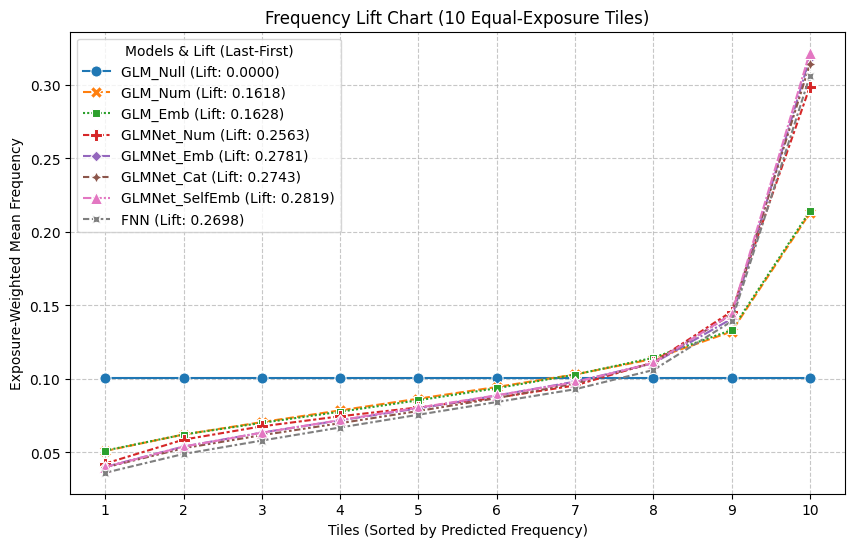

In [ ]:
multiple_lift(    
    y_true=y_test.values,
    exposure=v_test.values,
    y_pred_df=results_df_test,
    tiles=10
)